# IT Incident SLA Comliance Analysis

Service Level Agreement (SLA) compliance represents a critical performance metric in IT service management, directly impacting customer satisfaction, operational efficiency, and business continuity. Organizations invest substantial resources in incident management processes, yet many struggle with inconsistent SLA performance across different incident types, time periods, and organizational units. This comprehensive analysis examines IT incident data to identify systematic patterns affecting SLA compliance rates. Unlike traditional approaches that focus solely on incident closure times, this study investigates the complex interplay between incident classification systems (priority, impact, urgency), organizational factors (assignment groups, categories), process adherence variables (knowledge requirements, priority confirmation), and temporal patterns that influence service delivery outcomes.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pearsonr, ttest_ind
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn.impute import SimpleImputer, KNNImputer
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

## 1. Data Loading and Initial Exploration

In [49]:
# Load the data
# Note: The '?' character is used to represent missing values in this dataset
df = pd.read_csv('../data/incident_event_log_dataset.csv', na_values=['?'])
print(f"Dataset shape: {df.shape}")
print(f"Number of unique incidents: {df['number'].nunique()}")

Dataset shape: (141712, 37)
Number of unique incidents: 24918


In [50]:
# Display basic dataset information for initial understanding
print("\nFirst 3 rows of the dataset:")
print(df.head(3))


First 3 rows of the dataset:
       number incident_state  active  reassignment_count  reopen_count  \
0  INC0000045            New    True                   0             0   
1  INC0000045       Resolved    True                   0             0   
2  INC0000045       Resolved    True                   0             0   

   sys_mod_count  made_sla    caller_id     opened_by         opened_at  ...  \
0              0      True  Caller 2403  Opened by  8  29-02-2016 01:16  ...   
1              2      True  Caller 2403  Opened by  8  29-02-2016 01:16  ...   
2              3      True  Caller 2403  Opened by  8  29-02-2016 01:16  ...   

          notify problem_id change vendor caused_by closed_code  \
0  Do Not Notify        NaN    NaN    NaN       NaN      code 5   
1  Do Not Notify        NaN    NaN    NaN       NaN      code 5   
2  Do Not Notify        NaN    NaN    NaN       NaN      code 5   

       resolved_by       resolved_at         closed_at isParent  
0  Resolved by 14

In [51]:
# Display data types
print("\nData types:")
print(df.dtypes)


Data types:
number                     object
incident_state             object
active                       bool
reassignment_count          int64
reopen_count                int64
sys_mod_count               int64
made_sla                     bool
caller_id                  object
opened_by                  object
opened_at                  object
sys_created_by             object
sys_created_at             object
sys_updated_by             object
sys_updated_at             object
contact_type               object
location                   object
category                   object
subcategory                object
symptom                    object
cmdb_ci                    object
impact                     object
urgency                    object
priority                   object
assignment_group           object
assigned_to                object
knowledge                    bool
u_priority_confirmation      bool
notify                     object
problem_id                 object
c

In [52]:
# Display basic data information
print(f"\nBasic dataset information:")
print(f"- Total records: {len(df):,}")
print(f"- Number of columns: {df.shape[1]}")


Basic dataset information:
- Total records: 141,712
- Number of columns: 37


## 2. Data Processing

### (1) Data Cleansing

Accurate time data is essential for SLA analysis precision. This analysis prioritizes processing 
date fields that form the basis for closed time calculations.

In [53]:
# Convert date columns to datetime format for temporal analysis
# These fields are critical for calculating closed time and temporal patterns
date_columns = [
    'opened_at', 'resolved_at', 'closed_at', 'sys_created_at', 'sys_updated_at'
]

for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"- {col}: converted to datetime")
    else:
        print(f"- {col}: column not found in dataset")

- opened_at: converted to datetime
- resolved_at: converted to datetime
- closed_at: converted to datetime
- sys_created_at: converted to datetime
- sys_updated_at: converted to datetime


In [54]:
# Examine incident states to understand data completeness
print(f"\nIncident states in the dataset:")
if 'incident_state' in df.columns:
    print(df['incident_state'].value_counts())
else:
    print("Warning: 'incident_state' column not found")


Incident states in the dataset:
incident_state
Active                38716
New                   36407
Resolved              25751
Closed                24985
Awaiting User Info    14642
Awaiting Vendor         707
Awaiting Problem        461
Awaiting Evidence        38
-100                      5
Name: count, dtype: int64


In [55]:
# Filter for closed incidents only - we can only calculate closed time for completed incidents
# This is essential for SLA compliance analysis as ongoing incidents don't have closed times
closed_incidents = df[(df['incident_state'].isin(['Resolved', 'Closed']))
                      &  # Must be completed
                      (df['closed_at'].notna())  # Must have closed timestamp
                      &
                      (df['opened_at'].notna())  # Must have opening timestamp
                      ].copy()

print(f"\nFiltered to {len(closed_incidents):,} closed incidents")


Filtered to 20,554 closed incidents


In [56]:
# Calculate closed time in hours - primary performance metric
closed_incidents['closed_time_hours'] = (
    closed_incidents['closed_at'] -
    closed_incidents['opened_at']).dt.total_seconds() / 3600
print(f"Calculated closed time for all closed incidents")

# Remove data quality issues - negative closed times are logically impossible
before_cleaning = len(closed_incidents)
closed_incidents = closed_incidents[closed_incidents['closed_time_hours'] >= 0]
after_cleaning = len(closed_incidents)
print(f"Removed {before_cleaning - after_cleaning} incidents with negative closed time")

Calculated closed time for all closed incidents
Removed 6809 incidents with negative closed time


### (2) Handling Missing Data

- In IT incident data, missing values may represent business process characteristics 
rather than simple omissions.
- The strategy adopted here preserves meaning over indiscriminate removal.

In [57]:
# Analyze missing data patterns to inform strategy
print("Missing data analysis:")
missing_data = closed_incidents.isnull().sum()
missing_percentage = (missing_data / len(closed_incidents)) * 100

# Identify columns with significant missing data
significant_missing = missing_percentage[missing_percentage > 5]
if len(significant_missing) > 0:
    print("Columns with >5% missing data:")
    for col, pct in significant_missing.items():
        print(f"- {col}: {missing_data[col]:,} missing ({pct:.1f}%)")
else:
    print("No columns with significant missing data (>5%)")

Missing data analysis:
Columns with >5% missing data:
- sys_created_by: 6,050 missing (44.0%)
- sys_created_at: 6,050 missing (44.0%)
- symptom: 3,263 missing (23.7%)
- cmdb_ci: 13,715 missing (99.8%)
- assignment_group: 1,401 missing (10.2%)
- problem_id: 13,444 missing (97.8%)
- change: 13,691 missing (99.6%)
- vendor: 13,735 missing (99.9%)
- caused_by: 13,745 missing (100.0%)
- resolved_at: 882 missing (6.4%)


In [58]:
# Strategic missing data handling approach
# Only remove columns that are completely unusable (>95% missing)
extreme_missing_count = (missing_percentage > 95).sum()
columns_to_exclude = missing_percentage[missing_percentage > 95].index.tolist()

print(f"\nMissing Data Strategy:")
print(f"- Excluding {extreme_missing_count} columns with >95% missing data")
if columns_to_exclude:
    print(f"- Columns excluded: {columns_to_exclude}")
    closed_incidents = closed_incidents.drop(columns=columns_to_exclude)
    print(f"- Removed {len(columns_to_exclude)} unusable columns from dataset")
else:
    print("- No columns found with >95% missing data")


Missing Data Strategy:
- Excluding 5 columns with >95% missing data
- Columns excluded: ['cmdb_ci', 'problem_id', 'change', 'vendor', 'caused_by']
- Removed 5 unusable columns from dataset


In [59]:
# Missing Data Column Summary
print("Columns with missing data:")
final_missing = closed_incidents.isnull().sum()
for col, count in final_missing[final_missing > 0].items():
    pct = (count / len(closed_incidents)) * 100
    print(f"- {col}: {count:,} missing ({pct:.1f}%)")

complete_cols = (final_missing == 0).sum()
print(f"\nColumns with no missing data: {complete_cols}")
print(f"Total columns: {len(closed_incidents.columns)}")

Columns with missing data:
- caller_id: 4 missing (0.0%)
- opened_by: 606 missing (4.4%)
- sys_created_by: 6,050 missing (44.0%)
- sys_created_at: 6,050 missing (44.0%)
- location: 13 missing (0.1%)
- category: 13 missing (0.1%)
- subcategory: 15 missing (0.1%)
- symptom: 3,263 missing (23.7%)
- assignment_group: 1,401 missing (10.2%)
- assigned_to: 648 missing (4.7%)
- closed_code: 52 missing (0.4%)
- resolved_by: 55 missing (0.4%)
- resolved_at: 882 missing (6.4%)

Columns with no missing data: 20
Total columns: 33


### (3) Handling Outliers

In [60]:
# Analyse closed time distribution to identify outliers
# Closed time is our key performance metric and outliers can significantly impact analysis
closed_times = closed_incidents['closed_time_hours'].copy()

print(f"Closed time distribution analysis:")
print(f"- Mean: {closed_times.mean():.2f} hours")
print(f"- Median: {closed_times.median():.2f} hours")
print(f"- Standard deviation: {closed_times.std():.2f} hours")
print(f"- Min: {closed_times.min():.2f} hours")
print(f"- Max: {closed_times.max():.2f} hours")

Closed time distribution analysis:
- Mean: 3043.00 hours
- Median: 3021.62 hours
- Standard deviation: 1722.75 hours
- Min: 0.38 hours
- Max: 13335.02 hours


In [61]:
# Calculate skewness to understand distribution shape
skewness = closed_times.skew()
print(
    f"- Skewness: {skewness:.2f} ({'Highly right-skewed' if skewness > 2 else 'Moderately right-skewed' if skewness > 1 else 'Approximately normal'})"
)

- Skewness: 0.17 (Approximately normal)


In [62]:
# Outlier detection and extreme case identification
Q1 = closed_incidents['closed_time_hours'].quantile(0.25)
Q3 = closed_incidents['closed_time_hours'].quantile(0.75)
IQR = Q3 - Q1
iqr_outliers = closed_incidents['closed_time_hours'] > (Q3 + 1.5 * IQR)

max_closed = closed_incidents['closed_time_hours'].max()
print("Outlier Analysis:")
print(
    f"Outliers detected: {iqr_outliers.sum():,} incidents ({iqr_outliers.mean():.1%})"
)
print(
    f"CRITICAL: Maximum closed time = {max_closed:.0f} hours ({max_closed/24:.0f} days)"
)
print(
    f"This represents a {max_closed/24:.0f}-day system failure that must be analyzed"
)


Outlier Analysis:
Outliers detected: 28 incidents (0.2%)
CRITICAL: Maximum closed time = 13335 hours (556 days)
This represents a 556-day system failure that must be analyzed


**Retain outliers for complete SLA analysis**
- Outliers are retained in the dataset for complete SLA compliance analysis
- Extreme closed times represent real business scenarios that must be included in SLA performance evaluation, even if they skew statistical measures
- These cases may reveal critical process breakdowns requiring attention

### (4) Final Dataset Preparation

In [63]:
# Create final analysis dataset with unique incidents only
if 'closed_at' in closed_incidents.columns:
    latest_incidents = closed_incidents.sort_values('closed_at').groupby(
        'number').tail(1).copy()
    print("Using latest closed record for each incident")
else:
    latest_incidents = closed_incidents.drop_duplicates(subset=['number'],
                                                          keep='last').copy()
    print("Warning: closed_at not available, using simple deduplication")


# Deduplication verification
duplicates_removed = len(closed_incidents) - len(latest_incidents)
print(f"\nDeduplication summary:")
print(f"- Before: {len(closed_incidents):,} records")
print(f"- After: {len(latest_incidents):,} unique incidents")
print(f"- Duplicates removed: {duplicates_removed:,}")

if duplicates_removed > 0:
    duplicate_rate = duplicates_removed / len(closed_incidents)
    print(f"- Duplicate rate: {duplicate_rate:.1%}")

Using latest closed record for each incident

Deduplication summary:
- Before: 13,745 records
- After: 6,729 unique incidents
- Duplicates removed: 7,016
- Duplicate rate: 51.0%


## 3. Exploratory Data Analysis (EDA)

#### (1) SLA Performance Analysis

This section analyzes the existing made_sla field to understand current SLA compliance patterns and performance characteristics.

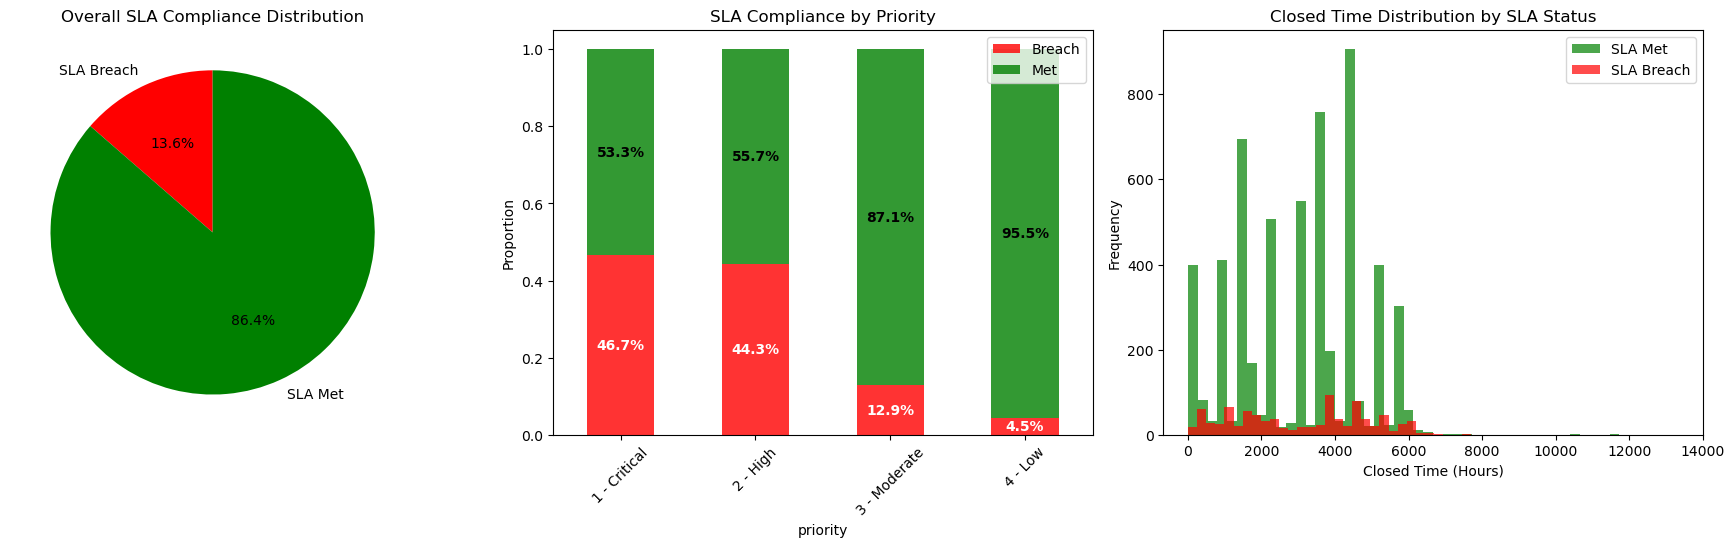


DETAILED ANALYSIS

Overall SLA Performance Summary:
- Total incidents analyzed: 6,729
- Overall compliance rate: 86.4%
- SLA breaches: 916 (13.6%)
- SLA compliant incidents: 5,813 (86.4%)

SLA Compliance by Priority:
- 1 - Critical   :  53.3% compliance (40/75)
                  Avg closed: 2639.3h, Median: 2256.5h
- 2 - High       :  55.7% compliance (78/140)
                  Avg closed: 3083.6h, Median: 3315.2h
- 3 - Moderate   :  87.1% compliance (5,460/6,268)
                  Avg closed: 3046.9h, Median: 3031.2h
- 4 - Low        :  95.5% compliance (235/246)
                  Avg closed: 3258.6h, Median: 3672.4h

Closed Time Analysis:
- SLA Met incidents:
  * Average: 3038.7 hours (126.6 days)
  * Median: 3017.3 hours (125.7 days)
  * Max: 13335.0 hours (555.6 days)
- SLA Breach incidents:
  * Average: 3128.3 hours (130.3 days)
  * Median: 3406.0 hours (141.9 days)
  * Max: 12399.3 hours (516.6 days)
- Performance Gap:
  * Average closed time gap: 89.6 hours (3.7 days)
  * Media

In [64]:
# Check if made_sla field exists
if 'made_sla' not in latest_incidents.columns:
    print("ERROR: made_sla field not found in dataset!")
    print("Available columns:", list(latest_incidents.columns))
else:
    # Convert made_sla to binary format (TRUE/FALSE -> 1/0)
    latest_incidents['sla_met'] = latest_incidents['made_sla'].map({
        True: 1,
        'TRUE': 1,
        't': 1,
        'T': 1,
        False: 0,
        'FALSE': 0,
        'f': 0,
        'F': 0
    })
    # SLA Target Variable Visualization
    plt.figure(figsize=(24, 15))

    # 1. SLA Compliance Distribution
    plt.subplot(3, 4, 1)
    compliance_counts = latest_incidents['sla_met'].value_counts().sort_index()
    colors = ['red', 'green']
    labels = ['SLA Breach', 'SLA Met']
    plt.pie(compliance_counts.values,
            labels=labels,
            autopct='%1.1f%%',
            colors=colors,
            startangle=90)
    plt.title('Overall SLA Compliance Distribution')

    # 2. SLA Compliance by Priority
    plt.subplot(3, 4, 2)
    if 'priority' in latest_incidents.columns:
        try:
            priority_sla = pd.crosstab(latest_incidents['priority'],
                                       latest_incidents['sla_met'],
                                       normalize='index')
            priority_sla.plot(kind='bar',
                              stacked=True,
                              color=['red', 'green'],
                              alpha=0.8,
                              ax=plt.gca())
            plt.title('SLA Compliance by Priority')
            plt.ylabel('Proportion')
            plt.xticks(rotation=45)
            plt.legend(['Breach', 'Met'])

            # Add percentage labels on bars
            for i, (priority, values) in enumerate(priority_sla.iterrows()):
                breach_rate = values[0] if 0 in values.index else 0
                compliance_rate = values[1] if 1 in values.index else 0

                plt.text(i,
                         breach_rate / 2,
                         f'{breach_rate:.1%}',
                         ha='center',
                         va='center',
                         fontweight='bold',
                         color='white')
                plt.text(i,
                         breach_rate + compliance_rate / 2,
                         f'{compliance_rate:.1%}',
                         ha='center',
                         va='center',
                         fontweight='bold',
                         color='black')

        except Exception as e:
            plt.text(0.5,
                     0.5,
                     f'Error: {str(e)}',
                     transform=plt.gca().transAxes)
            plt.title('SLA Compliance by Priority (Error)')
    else:
        plt.text(0.5,
                 0.5,
                 'Priority column not available',
                 transform=plt.gca().transAxes)
        plt.title('SLA Compliance by Priority (N/A)')

    # 3. Closed Time Distribution by SLA Status
    plt.subplot(3, 4, 3)
    sla_met_times = latest_incidents[latest_incidents['sla_met'] ==
                                     1]['closed_time_hours']
    sla_breach_times = latest_incidents[latest_incidents['sla_met'] ==
                                        0]['closed_time_hours']

    if len(sla_met_times) > 0 and len(sla_breach_times) > 0:
        # Use full data but limit X-axis for visual clarity
        plt.hist(sla_met_times,
                 bins=50,
                 alpha=0.7,
                 color='green',
                 label='SLA Met',
                 density=False)
        plt.hist(sla_breach_times,
                 bins=50,
                 alpha=0.7,
                 color='red',
                 label='SLA Breach',
                 density=False)
        plt.xlabel('Closed Time (Hours)')
        plt.ylabel('Frequency')
        plt.title('Closed Time Distribution by SLA Status')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Detailed Analysis
    print(f"\n" + "=" * 60)
    print(f"DETAILED ANALYSIS")
    print(f"=" * 60)

    # Calculate basic SLA metrics for overview
    overall_compliance = latest_incidents['sla_met'].mean()
    total_incidents = len(latest_incidents)
    breached_incidents = (latest_incidents['sla_met'] == 0).sum()

    print(f"\nOverall SLA Performance Summary:")
    print(f"- Total incidents analyzed: {total_incidents:,}")
    print(f"- Overall compliance rate: {overall_compliance:.1%}")
    print(
        f"- SLA breaches: {breached_incidents:,} ({(1-overall_compliance):.1%})"
    )
    print(
        f"- SLA compliant incidents: {total_incidents - breached_incidents:,} ({overall_compliance:.1%})"
    )

    # Priority-specific metrics
    if 'priority' in latest_incidents.columns:
        print(f"\nSLA Compliance by Priority:")
        priority_stats = latest_incidents.groupby('priority').agg({
            'sla_met': ['count', 'sum', 'mean'],
            'closed_time_hours': ['mean', 'median']
        }).round(3)
        priority_stats.columns = [
            'total_incidents', 'sla_met_count', 'compliance_rate',
            'avg_closed', 'median_closed'
        ]

        for priority in priority_stats.index:
            stats = priority_stats.loc[priority]
            breach_count = stats['total_incidents'] - stats['sla_met_count']
            breach_rate = 1 - stats['compliance_rate']
            print(
                f"- {priority:15}: {stats['compliance_rate']:6.1%} compliance ({int(stats['sla_met_count']):,}/{int(stats['total_incidents']):,})"
            )
            print(
                f"{'':17} Avg closed: {stats['avg_closed']:6.1f}h, Median: {stats['median_closed']:6.1f}h"
            )

    # Closed time analysis by SLA status
    if len(sla_met_times) > 0 and len(sla_breach_times) > 0:
        print(f"\nClosed Time Analysis:")
        print(f"- SLA Met incidents:")
        print(
            f"  * Average: {sla_met_times.mean():.1f} hours ({sla_met_times.mean()/24:.1f} days)"
        )
        print(
            f"  * Median: {sla_met_times.median():.1f} hours ({sla_met_times.median()/24:.1f} days)"
        )
        print(
            f"  * Max: {sla_met_times.max():.1f} hours ({sla_met_times.max()/24:.1f} days)"
        )

        print(f"- SLA Breach incidents:")
        print(
            f"  * Average: {sla_breach_times.mean():.1f} hours ({sla_breach_times.mean()/24:.1f} days)"
        )
        print(
            f"  * Median: {sla_breach_times.median():.1f} hours ({sla_breach_times.median()/24:.1f} days)"
        )
        print(
            f"  * Max: {sla_breach_times.max():.1f} hours ({sla_breach_times.max()/24:.1f} days)"
        )

        print(f"- Performance Gap:")
        avg_gap = sla_breach_times.mean() - sla_met_times.mean()
        median_gap = sla_breach_times.median() - sla_met_times.median()
        print(
            f"  * Average closed time gap: {avg_gap:.1f} hours ({avg_gap/24:.1f} days)"
        )
        print(
            f"  * Median closed time gap: {median_gap:.1f} hours ({median_gap/24:.1f} days)"
        )

**Key Performance Insights**
- Business SLA Framework: Analysis uses organization-defined SLA criteria from the made_sla field, providing direct measurement of actual business performance against established targets.
- Priority Performance Paradox: Critical incidents achieve only 53.3% compliance compared to 95.5% for Low priority incidents, creating a 42.2% performance gap that suggests either resource constraints for complex issues or unrealistic SLA targets for high-priority incidents.
- Limited Performance Gap: SLA breaches result in 89.6 hour (3.7 day) average delay compared to compliant incidents, though median gap is larger at 388.7 hours (16.2 days), indicating that while most breaches are modest, some cases experience significant delays.
- Extended Closure Timeframes: Both SLA-met and breached incidents show extended closed times averaging 126-130 days, suggesting this dataset may represent complex projects or change requests rather than typical IT incidents, with maximum cases extending beyond 500 days.

#### (2) Priority/Impact/Urgency Classification Analysis

This analysis quantitatively evaluates how incident classification systems (Priority, Impact, Urgency) affect SLA performance outcomes.

In [65]:
# Define classification variables for analysis
classification_vars = ['priority', 'impact', 'urgency']
available_classification = [
    var for var in classification_vars if var in latest_incidents.columns
]

print(f"Available classification variables: {available_classification}")
print(f"Total incidents for analysis: {len(latest_incidents):,}")

Available classification variables: ['priority', 'impact', 'urgency']
Total incidents for analysis: 6,729


In [66]:
# Data preprocessing - safe numeric extraction and validation
def safe_extract_numeric(series, column_name):
    """Safely extract and validate numeric codes"""
    # Extract numbers using regex
    numeric_series = series.str.extract('(\d+)', expand=False)

    # Attempt numeric conversion
    try:
        numeric_series = pd.to_numeric(numeric_series, errors='coerce')

        # Check extraction success rate
        success_rate = numeric_series.notna().mean()
        print(f"- {column_name}: {success_rate:.1%} extraction success")

        if success_rate < 0.8:  # Warning if less than 80%
            print(
                f"  Warning: {column_name} extraction rate is low. Check data format."
            )

        return numeric_series
    except Exception as e:
        print(f"- {column_name} numeric extraction failed: {e}")
        return pd.Series([np.nan] * len(series))


# Extract numeric codes for each classification variable
for var in available_classification:
    if var in latest_incidents.columns:
        latest_incidents[f'{var}_num'] = safe_extract_numeric(
            latest_incidents[var], var)


# Priority pattern analysis (actual data patterns instead of complex rules)
def analyze_priority_patterns():
    """Analyze priority assignment patterns from actual data"""
    if all(col in latest_incidents.columns
           for col in ['impact_num', 'urgency_num', 'priority_num']):

        # Generate actual priority matrix
        try:
            priority_matrix = latest_incidents.pivot_table(
                values='priority_num',
                index='impact_num',
                columns='urgency_num',
                aggfunc=lambda x: x.mode().iloc[0]
                if len(x.mode()) > 0 else np.nan  # Most frequent value
            )

            print("\nActual Priority Assignment Patterns (Impact vs Urgency):")
            print(priority_matrix)
        except Exception as e:
            print(f"Priority matrix generation failed: {e}")
            # Alternative: use simple crosstab
            priority_matrix = pd.crosstab(latest_incidents['impact_num'],
                                          latest_incidents['urgency_num'],
                                          latest_incidents['priority_num'],
                                          aggfunc='mean')
            print("\nAlternative: Average Priority by Impact-Urgency:")
            print(priority_matrix)

        # Consistency analysis
        consistency_check = latest_incidents.groupby(
            ['impact_num', 'urgency_num']).agg({
                'priority_num': ['count', 'nunique', 'std']
            }).round(2)

        inconsistent_combinations = consistency_check[consistency_check[(
            'priority_num', 'nunique')] > 1]

        if len(inconsistent_combinations) > 0:
            print(
                f"\nInconsistent combinations found: {len(inconsistent_combinations)}"
            )
            print("Priority variance by Impact-Urgency combinations:")
            print(inconsistent_combinations.head())
        else:
            print(
                "\nAll Impact-Urgency combinations have consistent Priority assignments."
            )

        return priority_matrix
    else:
        print("Insufficient columns for Priority pattern analysis.")
        # Check available columns
        available_cols = [
            col for col in ['impact_num', 'urgency_num', 'priority_num']
            if col in latest_incidents.columns
        ]
        missing_cols = [
            col for col in ['impact_num', 'urgency_num', 'priority_num']
            if col not in latest_incidents.columns
        ]
        print(f"Available columns: {available_cols}")
        print(f"Missing columns: {missing_cols}")
        return None


# Execute actual pattern analysis
priority_matrix = analyze_priority_patterns()

- priority: 100.0% extraction success
- impact: 100.0% extraction success
- urgency: 100.0% extraction success

Actual Priority Assignment Patterns (Impact vs Urgency):
urgency_num    1    2    3
impact_num                
1            1.0  2.0  NaN
2            2.0  3.0  4.0
3            NaN  4.0  4.0

All Impact-Urgency combinations have consistent Priority assignments.


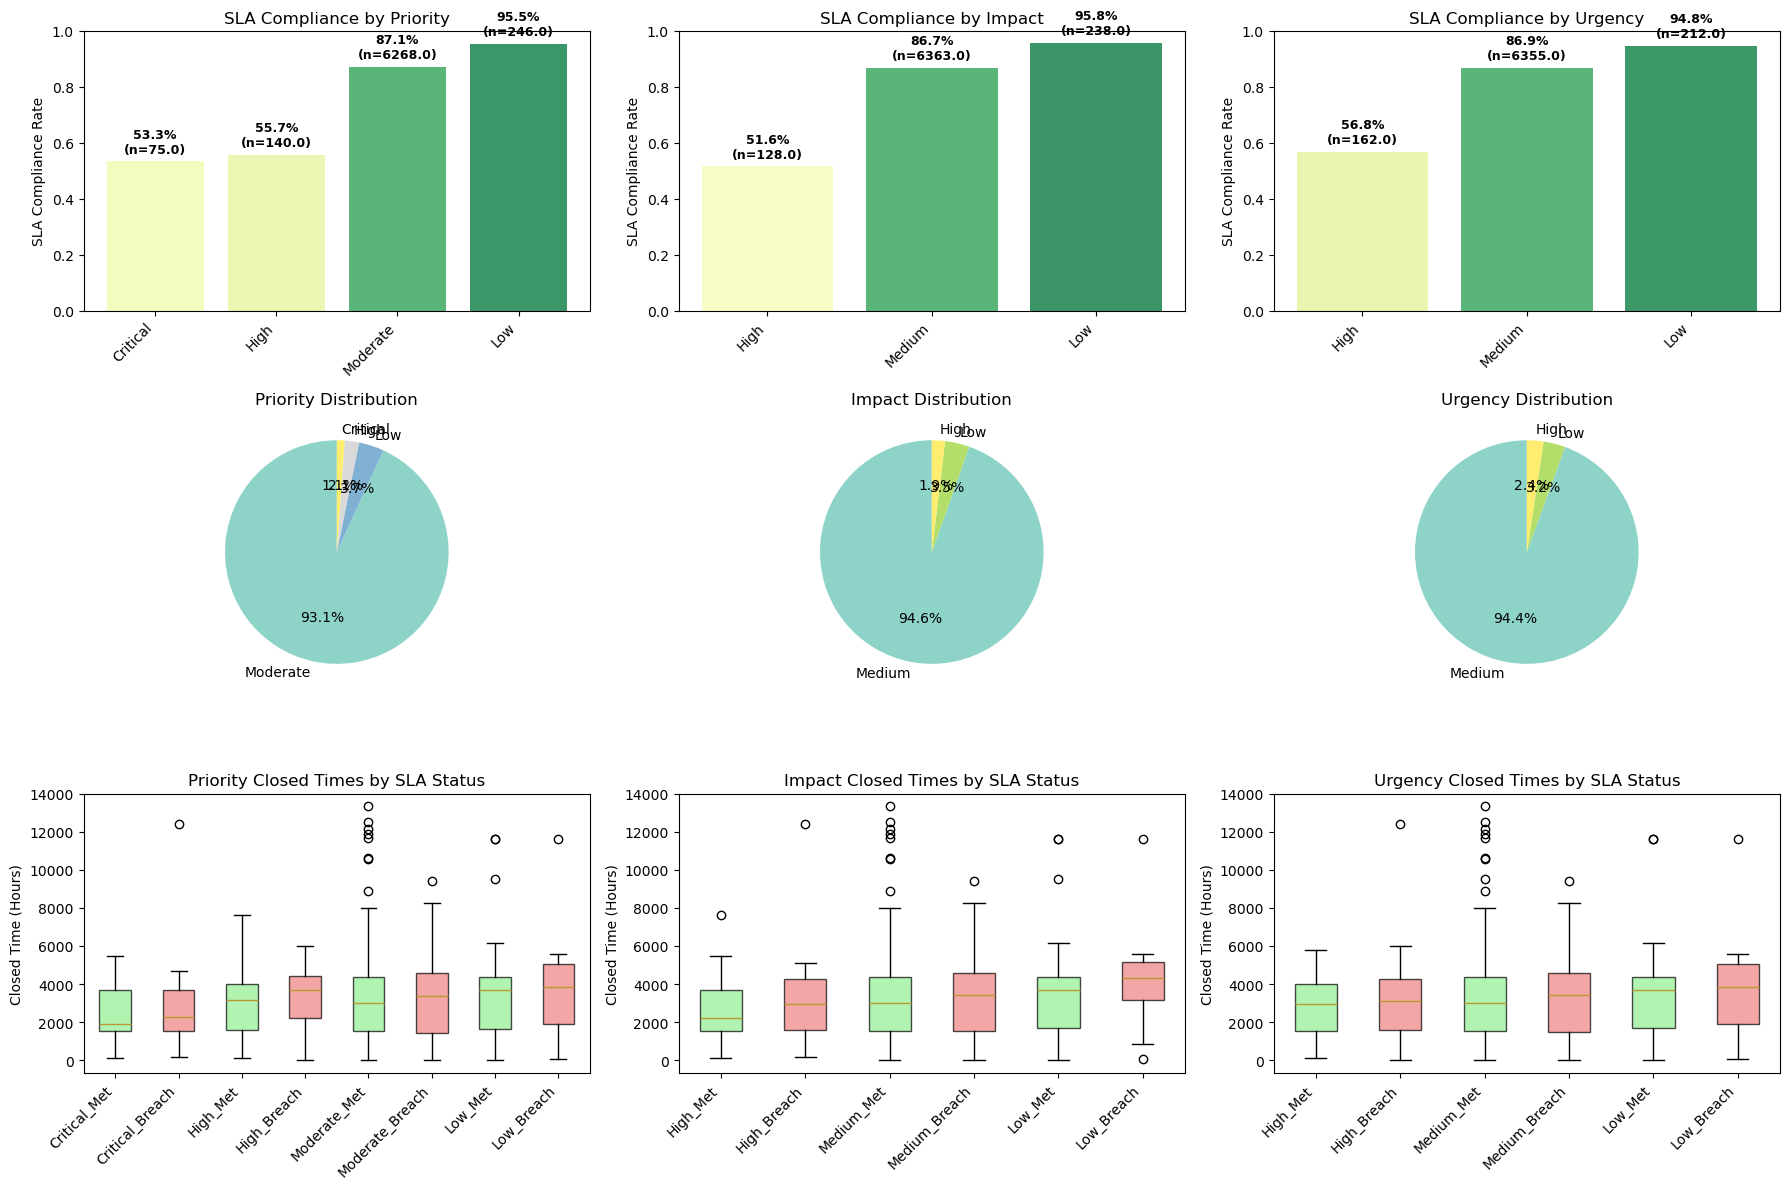


DETAILED ANALYSIS

Priority Closed Time Statistics:

  1 - Critical:
    SLA Met (n=40):
      - Median: 1885.3h (78.6 days)
      - Mean: 2518.3h (104.9 days)
      - Max: 5500.1h (229.2 days)
      - 95th percentile: 5112.0h
      - Cases >1000h: 34 (85.0%)
    SLA Breach (n=35):
      - Median: 2262.2h (94.3 days)
      - Mean: 2777.6h (115.7 days)
      - Max: 12399.3h (516.6 days)
      - 95th percentile: 4628.7h
      - Cases >1000h: 30 (85.7%)
      - Variance ratio (Breach/Met): 2.0x

  2 - High:
    SLA Met (n=78):
      - Median: 3160.2h (131.7 days)
      - Mean: 2998.4h (124.9 days)
      - Max: 7633.3h (318.1 days)
      - 95th percentile: 5091.7h
      - Cases >1000h: 69 (88.5%)
    SLA Breach (n=62):
      - Median: 3694.1h (153.9 days)
      - Mean: 3190.7h (132.9 days)
      - Max: 6000.8h (250.0 days)
      - 95th percentile: 4773.9h
      - Cases >1000h: 53 (85.5%)
      - Variance ratio (Breach/Met): 1.0x

  3 - Moderate:
    SLA Met (n=5460):
      - Median: 3007.

In [67]:
if available_classification:
    n_vars = len(available_classification)
    fig = plt.figure(figsize=(6 * n_vars, 12))

    # Statistical results storage
    sla_summaries = {}
    distribution_summaries = {}
    closed_time_summaries = {}

    for i, var in enumerate(available_classification):
        # 1. SLA compliance rate (based on made_sla)
        plt.subplot(3, n_vars, i + 1)
        var_sla = latest_incidents.groupby(var)['sla_met'].agg(
            ['mean', 'count']).sort_values('mean')

        # Store for later output
        sla_summaries[var] = var_sla

        colors = plt.cm.RdYlGn(var_sla['mean'])
        bars = plt.bar(range(len(var_sla)),
                       var_sla['mean'],
                       color=colors,
                       alpha=0.8)

        # Clean up labels
        clean_labels = [
            str(idx).split(' - ')[1] if ' - ' in str(idx) else str(idx)
            for idx in var_sla.index
        ]

        plt.xticks(range(len(var_sla)), clean_labels, rotation=45, ha='right')
        plt.ylabel('SLA Compliance Rate')
        plt.title(f'SLA Compliance by {var.title()}')
        plt.ylim(0, 1)

        # Add value labels
        for j, (idx, data) in enumerate(var_sla.iterrows()):
            plt.text(j,
                     data['mean'] + 0.02,
                     f'{data["mean"]:.1%}\n(n={data["count"]})',
                     ha='center',
                     va='bottom',
                     fontsize=9,
                     weight='bold')

        # 2. Distribution pie chart
        plt.subplot(3, n_vars, i + 1 + n_vars)
        var_counts = latest_incidents[var].value_counts()

        # Store for later output
        distribution_summaries[var] = var_counts

        # Create pie chart with clean labels
        clean_pie_labels = [
            str(label).split(' - ')[1] if ' - ' in str(label) else str(label)
            for label in var_counts.index
        ]

        colors_pie = plt.cm.Set3(np.linspace(0, 1, len(var_counts)))
        plt.pie(var_counts.values,
                labels=clean_pie_labels,
                autopct='%1.1f%%',
                colors=colors_pie,
                startangle=90)
        plt.title(f'{var.title()} Distribution')

        # 3. Closed time analysis by SLA status
        plt.subplot(3, n_vars, i + 1 + 2 * n_vars)

        # Prepare data for box plot
        var_values = latest_incidents[var].unique()
        box_data = []
        box_labels = []
        box_colors = []

        closed_time_data = {}
        for val in sorted(var_values):
            if pd.notna(val):
                val_data = latest_incidents[latest_incidents[var] == val]
                closed_time_data[val] = val_data

                # SLA met cases
                met_times = val_data[val_data['sla_met'] ==
                                     1]['closed_time_hours']
                if len(met_times) > 0:
                    box_data.append(met_times)
                    clean_val = str(val).split(' - ')[1] if ' - ' in str(
                        val) else str(val)
                    box_labels.append(f"{clean_val}_Met")
                    box_colors.append('lightgreen')

                # SLA breach cases
                breach_times = val_data[val_data['sla_met'] ==
                                        0]['closed_time_hours']
                if len(breach_times) > 0:
                    box_data.append(breach_times)
                    clean_val = str(val).split(' - ')[1] if ' - ' in str(
                        val) else str(val)
                    box_labels.append(f"{clean_val}_Breach")
                    box_colors.append('lightcoral')

        # Store for later output
        closed_time_summaries[var] = closed_time_data

        if box_data:
            box_plot = plt.boxplot(box_data,
                                   patch_artist=True,
                                   showfliers=True)  # Show outliers
            for patch, color in zip(box_plot['boxes'], box_colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)

            plt.xticks(range(1,
                             len(box_data) + 1),
                       box_labels,
                       rotation=45,
                       ha='right')
            plt.ylabel('Closed Time (Hours)')
            plt.title(f'{var.title()} Closed Times by SLA Status')
        else:
            plt.text(0.5,
                     0.5,
                     'Insufficient data for analysis',
                     transform=plt.gca().transAxes,
                     ha='center',
                     va='center')
            plt.title(f'{var.title()} Closed Times (Insufficient Data)')

    plt.tight_layout()
    plt.show()

    print(f"\n{'='*60}")
    print("DETAILED ANALYSIS")
    print(f"{'='*60}")

    for var in available_classification:
        if var in closed_time_summaries:
            print(f"\n{var.title()} Closed Time Statistics:")

            for category, data in closed_time_summaries[var].items():
                if len(data) > 0:
                    # SLA Met cases
                    met_times = data[data['sla_met'] ==
                                     1]['closed_time_hours']
                    breach_times = data[data['sla_met'] ==
                                        0]['closed_time_hours']

                    print(f"\n  {category}:")

                    if len(met_times) > 0:
                        print(f"    SLA Met (n={len(met_times)}):")
                        print(
                            f"      - Median: {met_times.median():.1f}h ({met_times.median()/24:.1f} days)"
                        )
                        print(
                            f"      - Mean: {met_times.mean():.1f}h ({met_times.mean()/24:.1f} days)"
                        )
                        print(
                            f"      - Max: {met_times.max():.1f}h ({met_times.max()/24:.1f} days)"
                        )
                        print(
                            f"      - 95th percentile: {met_times.quantile(0.95):.1f}h"
                        )
                        extreme_met = (met_times > 1000).sum()
                        print(
                            f"      - Cases >1000h: {extreme_met} ({extreme_met/len(met_times):.1%})"
                        )

                    if len(breach_times) > 0:
                        print(f"    SLA Breach (n={len(breach_times)}):")
                        print(
                            f"      - Median: {breach_times.median():.1f}h ({breach_times.median()/24:.1f} days)"
                        )
                        print(
                            f"      - Mean: {breach_times.mean():.1f}h ({breach_times.mean()/24:.1f} days)"
                        )
                        print(
                            f"      - Max: {breach_times.max():.1f}h ({breach_times.max()/24:.1f} days)"
                        )
                        print(
                            f"      - 95th percentile: {breach_times.quantile(0.95):.1f}h"
                        )
                        extreme_breach = (breach_times > 1000).sum()
                        print(
                            f"      - Cases >1000h: {extreme_breach} ({extreme_breach/len(breach_times):.1%})"
                        )

                        # Variance ratio
                        if len(met_times) > 0:
                            variance_ratio = breach_times.var(
                            ) / met_times.var() if met_times.var(
                            ) > 0 else float('inf')
                            print(
                                f"      - Variance ratio (Breach/Met): {variance_ratio:.1f}x"
                            )

        # Overall extreme cases analysis
        print(f"\n{'='*60}")
        print("EXTREME CASES ANALYSIS")
        print(f"{'='*60}")

        total_incidents = len(latest_incidents)
        extreme_1000h = latest_incidents[
            latest_incidents['closed_time_hours'] > 1000]
        extreme_5000h = latest_incidents[
            latest_incidents['closed_time_hours'] > 5000]
        extreme_8000h = latest_incidents[
            latest_incidents['closed_time_hours'] > 8000]

        print(f"Total incidents analyzed: {total_incidents:,}")
        print(
            f"Cases >1000h (42 days): {len(extreme_1000h):,} ({len(extreme_1000h)/total_incidents:.2%})"
        )
        print(
            f"Cases >5000h (208 days): {len(extreme_5000h):,} ({len(extreme_5000h)/total_incidents:.2%})"
        )
        print(
            f"Cases >8000h (333 days): {len(extreme_8000h):,} ({len(extreme_8000h)/total_incidents:.2%})"
        )
else:
    print("No classification variables available for analysis")

 **Key Performance Insights** 
- Priority Performance Paradox: High-priority incidents achieved only 53.3% SLA compliance compared to 95.5% for low-priority incidents, creating a 42.2% performance gap that suggests either resource constraints for complex issues or unrealistic SLA targets.
- Consistent Cross-Variable Patterns: Impact and urgency show similar inverse relationships (High impact: 51.6%, High urgency: 56.8% vs Low levels: ~95%). They exhibit comparable performance gaps of 44.2% and 38.0% respectively, confirming systematic resource allocation issues across all classification dimensions.
- Classification Concentration Phenomenon: 93-95% of incidents cluster in medium/moderate categories while high/urgent represent only 1-3% of volume. This suggests conservative classification practices that may obscure true business impact and create resource allocation inefficiencies for genuinely critical cases.
- Extended Closure Patterns: Analysis reveals 84.75% of all incidents exceed 42 days (1000 hours) for closure, with median times around 125-155 days, suggesting this dataset represents complex projects or major changes rather than typical IT incidents.

#### (3) Boolean Process Variables Analysis

This analysis quantitatively evaluates how binary process decisions (knowledge consultation, priority confirmation, notifications) influence SLA compliance and operational efficiency.

In [68]:
# Define boolean process variables for analysis
boolean_vars = ['knowledge', 'u_priority_confirmation', 'notify']
available_boolean = [
   var for var in boolean_vars if var in latest_incidents.columns
]

print(f"Available boolean variables: {available_boolean}")
print(f"Total incidents for analysis: {len(latest_incidents):,}")

Available boolean variables: ['knowledge', 'u_priority_confirmation', 'notify']
Total incidents for analysis: 6,729


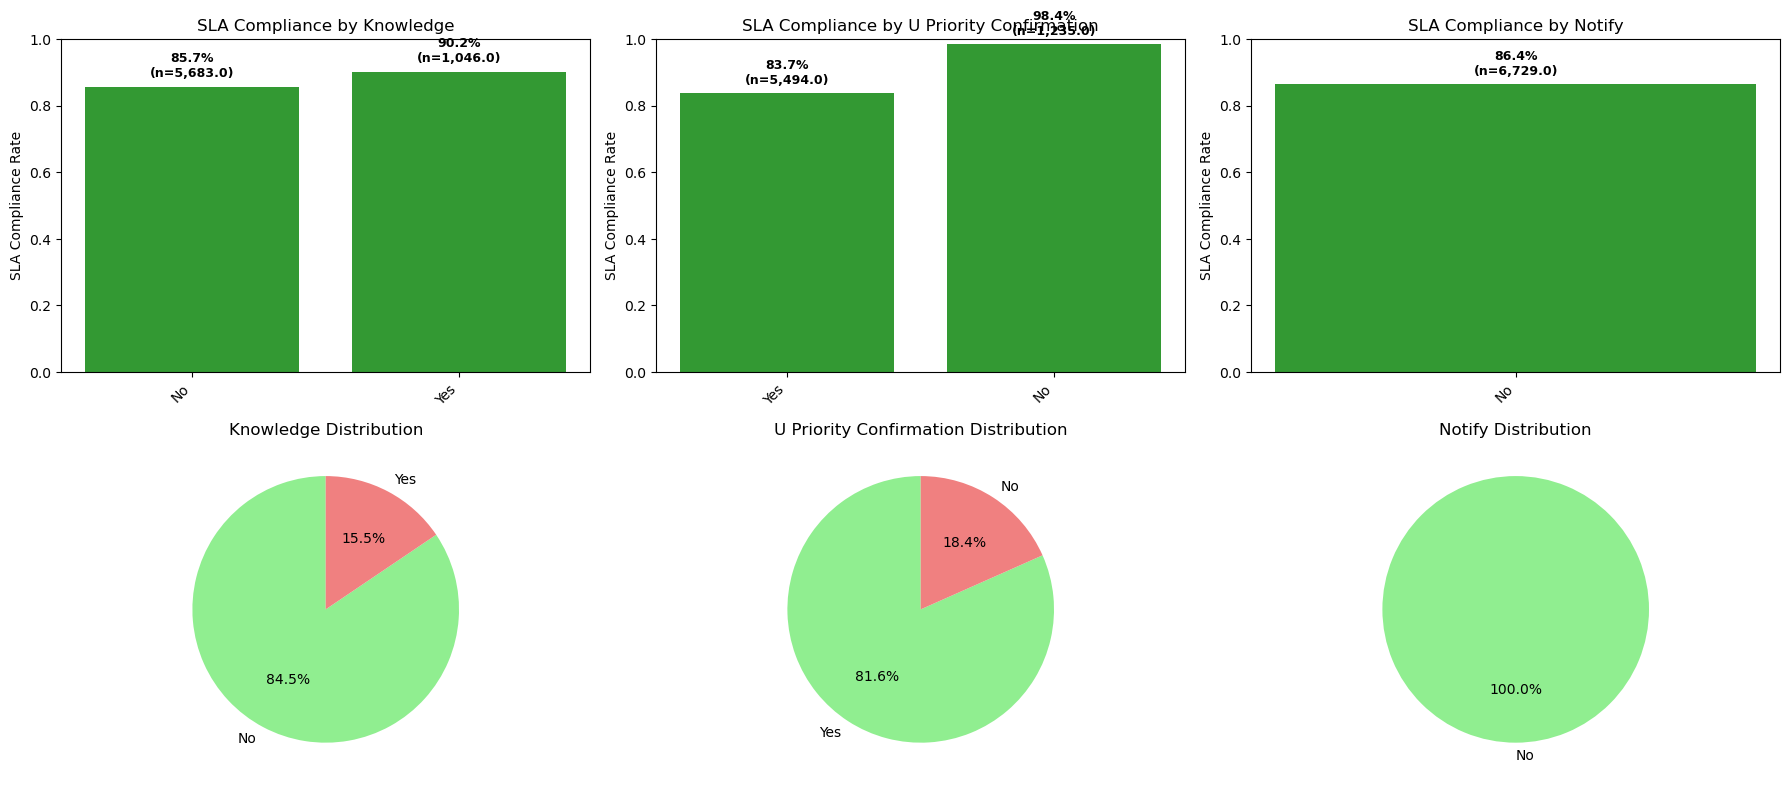


DETAILED ANALYSIS

Knowledge:
  - No: 85.7% SLA compliance (n=5,683.0)
  - Yes: 90.2% SLA compliance (n=1,046.0)
  - Performance Impact: +4.5%
  - Usage Pattern:
    * No: 5,683 cases (84.5%)
    * Yes: 1,046 cases (15.5%)

U Priority Confirmation:
  - Yes: 83.7% SLA compliance (n=5,494.0)
  - No: 98.4% SLA compliance (n=1,235.0)
  - Performance Impact: -14.7%
  - Usage Pattern:
    * Yes: 5,494 cases (81.6%)
    * No: 1,235 cases (18.4%)

Notify:
  - No: 86.4% SLA compliance (n=6,729.0)
  - Usage Pattern:
    * No: 6,729 cases (100.0%)


In [69]:
if available_boolean:
    # Enhanced boolean variable visualization
    n_vars = len(available_boolean)
    plt.figure(figsize=(6 * n_vars, 12))

    # Statistical results storage
    boolean_sla_summaries = {}
    boolean_distribution_summaries = {}

    for i, var in enumerate(available_boolean):
        # Convert boolean values to consistent format
        latest_incidents[f'{var}_clean'] = latest_incidents[var].map({
            True:
            'Yes',
            'TRUE':
            'Yes',
            't':
            'Yes',
            'T':
            'Yes',
            1:
            'Yes',
            False:
            'No',
            'FALSE':
            'No',
            'f':
            'No',
            'F':
            'No',
            0:
            'No',
            'Do Not Notify':
            'No',
            'Send Email':
            'Yes'
        })

        # 1. SLA compliance rate by boolean value
        plt.subplot(3, n_vars, i + 1)
        var_sla = latest_incidents.groupby(f'{var}_clean')['sla_met'].agg(
            ['mean', 'count']).sort_values('mean')

        # Store for later output
        boolean_sla_summaries[var] = var_sla

        # Color mapping based on performance
        colors = [
            'red' if x < 0.7 else 'orange' if x < 0.8 else 'green'
            for x in var_sla['mean']
        ]
        bars = plt.bar(range(len(var_sla)),
                       var_sla['mean'],
                       color=colors,
                       alpha=0.8)

        plt.xticks(range(len(var_sla)), var_sla.index, rotation=45, ha='right')
        plt.ylabel('SLA Compliance Rate')
        plt.title(f'SLA Compliance by {var.replace("_", " ").title()}')
        plt.ylim(0, 1)

        # Add value labels
        for j, (idx, data) in enumerate(var_sla.iterrows()):
            plt.text(j,
                     data['mean'] + 0.02,
                     f'{data["mean"]:.1%}\n(n={data["count"]:,})',
                     ha='center',
                     va='bottom',
                     fontsize=9,
                     weight='bold')

        # 2. Distribution pie chart
        plt.subplot(3, n_vars, i + 1 + n_vars)
        var_counts = latest_incidents[f'{var}_clean'].value_counts()

        # Store for later output
        boolean_distribution_summaries[var] = var_counts

        # Create pie chart
        colors_pie = ['lightgreen', 'lightcoral',
                      'lightgray'][:len(var_counts)]
        plt.pie(var_counts.values,
                labels=var_counts.index,
                autopct='%1.1f%%',
                colors=colors_pie,
                startangle=90)
        plt.title(f'{var.replace("_", " ").title()} Distribution')

    plt.tight_layout()
    plt.show()

    # Detailed Boolean Variable Analysis
    print(f"\n{'='*60}")
    print("DETAILED ANALYSIS")
    print(f"{'='*60}")

    # Process quality impact analysis
    for var in available_boolean:
        if var in boolean_sla_summaries:
            var_data = boolean_sla_summaries[var]

            print(f"\n{var.replace('_', ' ').title()}:")

            # Show all categories and their performance
            for category, data in var_data.iterrows():
                print(
                    f"  - {category}: {data['mean']:.1%} SLA compliance (n={data['count']:,})"
                )

            # Calculate and show performance differences
            if 'Yes' in var_data.index and 'No' in var_data.index:
                yes_performance = var_data.loc['Yes', 'mean']
                no_performance = var_data.loc['No', 'mean']
                performance_impact = yes_performance - no_performance

                print(f"  - Performance Impact: {performance_impact:+.1%}")

            # Distribution insights
            if var in boolean_distribution_summaries:
                dist_data = boolean_distribution_summaries[var]
                total_cases = dist_data.sum()
                print(f"  - Usage Pattern:")
                for category, count in dist_data.items():
                    percentage = (count / total_cases) * 100
                    print(
                        f"    * {category}: {count:,} cases ({percentage:.1f}%)"
                    )

else:
    print("No boolean variables available for analysis")
    print("Available columns:", [
        col for col in latest_incidents.columns if col.lower() in
        ['knowledge', 'notify', 'active', 'u_priority_confirmation']
    ])

**Key Performance Insights**

- Knowledge Enhancement Effect: Incidents requiring knowledge base consultation show 4.5% better SLA performance (90.2% vs 85.7%), suggesting that knowledge resources effectively support incident closure despite being used in only 15.5% of cases.
- Priority Confirmation Paradox: Cases with priority confirmation achieve 14.7% worse SLA compliance (83.7% vs 98.4%), indicating that priority confirmation may be triggered by more complex cases requiring additional validation, though it's standardized across 81.6% of incidents.
- Notification Uniformity: All incidents in the dataset show "Do Not Notify" status (100.0%), indicating a consistent notification policy with no variation to analyze.
- Process Quality Impact: Knowledge utilization and priority confirmation processes create measurable SLA performance differences, confirming substantial impact on organizational operational efficiency.

#### (4) Assignment Group Analysis

This analysis examines organizational performance variations across different assignment groups to identify capability gaps, resource allocation patterns, and operational efficiency differences.

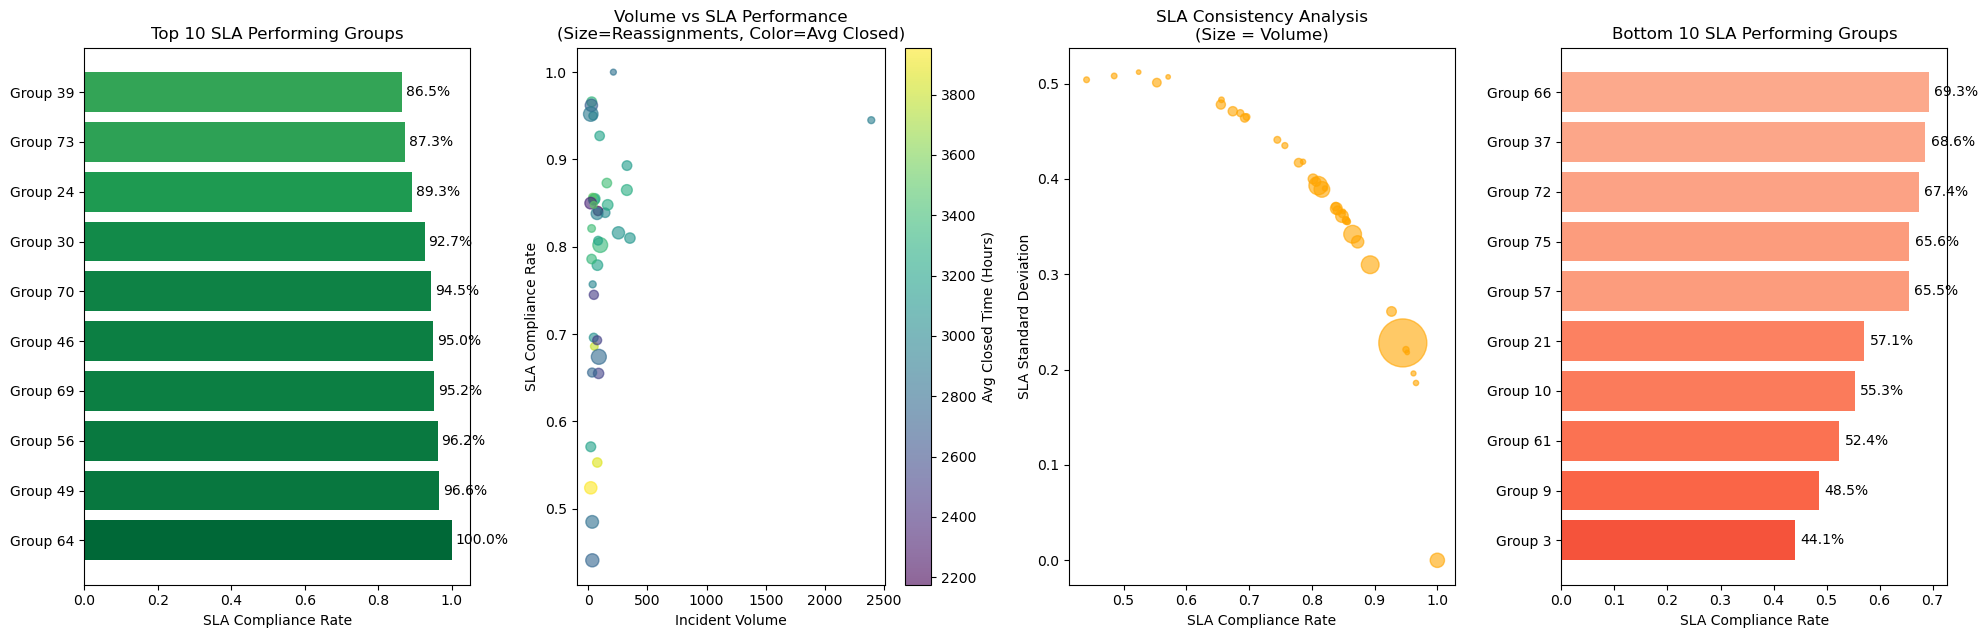


DETAILED ANALYSIS

Overall Group Performance Statistics:
- Total groups analyzed: 39
- Average SLA compliance: 78.8%
- Performance range: 44.1% - 100.0%
- Performance gap: 55.9%

Volume Distribution Analysis:
- Total incidents handled: 5,866
- High-volume groups (top 20%): 8 groups handling 4,185 incidents
- High-volume group avg performance: 88.1%

Operational Efficiency Analysis:
- Average reassignment rate: 1.10
- Groups with below-average reassignments: 22 (56.4%)
- Their average SLA performance: 80.5%

Closed Time Patterns:
- Average closed time: 3080.3 hours
- Fastest average closed: 2175.2 hours
- Slowest average closed: 3955.3 hours

Performance Tier Analysis:
- Top 5 groups average: 96.6% SLA compliance
- Bottom 5 groups average: 51.5% SLA compliance
- Top tier handles 328 incidents (5.6% of total)
- Bottom tier handles 185 incidents (3.2% of total)

Top 5 SLA Performing Groups:
Group | Incidents | SLA Rate | Avg Closed | Reassignments
----------------------------------------

In [70]:
if 'assignment_group' in latest_incidents.columns:
    try:
        group_sla_performance = latest_incidents.groupby(
            'assignment_group').agg({
                'sla_met': ['count', 'mean', 'std'],
                'closed_time_hours':
                'mean',
                'reassignment_count':
                'mean' if 'reassignment_count' in latest_incidents.columns else
                lambda x: np.nan
            }).round(3)

        group_sla_performance.columns = [
            'incident_count', 'sla_compliance_rate', 'sla_std',
            'avg_closed', 'avg_reassignments'
        ]

        # Filter groups with sufficient volume for reliable organizational performance comparison
        # Small groups (< 20 incidents) may show extreme percentages due to sample size limitations
        significant_groups = group_sla_performance[group_sla_performance['incident_count'] >= 20]

        if len(significant_groups) > 0:
            # Enhanced assignment group visualization
            plt.figure(figsize=(20, 12))

            # 1. SLA compliance ranking - Identifies best practices and training needs
            plt.subplot(2, 4, 1)
            top_performers = significant_groups.nlargest(
                10, 'sla_compliance_rate')
            colors = plt.cm.RdYlGn(top_performers['sla_compliance_rate'])
            bars = plt.barh(range(len(top_performers)),
                            top_performers['sla_compliance_rate'],
                            color=colors)
            plt.yticks(range(len(top_performers)),
                       [name[:15] for name in top_performers.index])
            plt.xlabel('SLA Compliance Rate')
            plt.title('Top 10 SLA Performing Groups')

            for i, (idx, rate) in enumerate(
                    top_performers['sla_compliance_rate'].items()):
                plt.text(rate + 0.01, i, f'{rate:.1%}', va='center')

            # 2. Volume vs SLA performance scatter - Resource allocation insights
            plt.subplot(2, 4, 2)
            scatter = plt.scatter(significant_groups['incident_count'],
                                  significant_groups['sla_compliance_rate'],
                                  s=significant_groups['avg_reassignments'] *
                                  50,
                                  alpha=0.6,
                                  c=significant_groups['avg_closed'],
                                  cmap='viridis')
            plt.xlabel('Incident Volume')
            plt.ylabel('SLA Compliance Rate')
            plt.title(
                'Volume vs SLA Performance\n(Size=Reassignments, Color=Avg Closed)'
            )
            plt.colorbar(scatter, label='Avg Closed Time (Hours)')

            # 3. SLA consistency analysis - Identifies groups with unstable performance
            plt.subplot(2, 4, 3)
            plt.scatter(significant_groups['sla_compliance_rate'],
                        significant_groups['sla_std'],
                        s=significant_groups['incident_count'] * 0.5,
                        alpha=0.6,
                        color='orange')
            plt.xlabel('SLA Compliance Rate')
            plt.ylabel('SLA Standard Deviation')
            plt.title('SLA Consistency Analysis\n(Size = Volume)')

            # 4. Worst performing groups - Immediate intervention targets
            plt.subplot(2, 4, 4)
            worst_performers = significant_groups.nsmallest(
                10, 'sla_compliance_rate')
            colors = plt.cm.Reds(1 - worst_performers['sla_compliance_rate'])
            bars = plt.barh(range(len(worst_performers)),
                            worst_performers['sla_compliance_rate'],
                            color=colors)
            plt.yticks(range(len(worst_performers)),
                       [name[:15] for name in worst_performers.index])
            plt.xlabel('SLA Compliance Rate')
            plt.title('Bottom 10 SLA Performing Groups')

            for i, (idx, rate) in enumerate(
                    worst_performers['sla_compliance_rate'].items()):
                plt.text(rate + 0.01, i, f'{rate:.1%}', va='center')

            plt.tight_layout()
            plt.show()

            # Detailed Assignment Group Analysis
            print(f"\n{'='*60}")
            print("DETAILED ANALYSIS")
            print(f"{'='*60}")

            # Overall statistics
            print(f"\nOverall Group Performance Statistics:")
            print(f"- Total groups analyzed: {len(significant_groups)}")
            print(
                f"- Average SLA compliance: {significant_groups['sla_compliance_rate'].mean():.1%}"
            )
            print(
                f"- Performance range: {significant_groups['sla_compliance_rate'].min():.1%} - {significant_groups['sla_compliance_rate'].max():.1%}"
            )
            print(
                f"- Performance gap: {significant_groups['sla_compliance_rate'].max() - significant_groups['sla_compliance_rate'].min():.1%}"
            )

            # Volume analysis
            print(f"\nVolume Distribution Analysis:")
            total_incidents = significant_groups['incident_count'].sum()
            high_volume_threshold = significant_groups[
                'incident_count'].quantile(0.8)
            high_volume_groups = significant_groups[
                significant_groups['incident_count'] >= high_volume_threshold]

            print(f"- Total incidents handled: {total_incidents:,}")
            print(
                f"- High-volume groups (top 20%): {len(high_volume_groups)} groups handling {high_volume_groups['incident_count'].sum():,} incidents"
            )
            print(
                f"- High-volume group avg performance: {high_volume_groups['sla_compliance_rate'].mean():.1%}"
            )

            # Efficiency analysis
            print(f"\nOperational Efficiency Analysis:")
            if 'avg_reassignments' in significant_groups.columns and significant_groups[
                    'avg_reassignments'].notna().any():
                avg_reassignments = significant_groups[
                    'avg_reassignments'].mean()
                print(f"- Average reassignment rate: {avg_reassignments:.2f}")

                low_reassign_groups = significant_groups[
                    significant_groups['avg_reassignments'] <=
                    avg_reassignments]
                print(
                    f"- Groups with below-average reassignments: {len(low_reassign_groups)} ({len(low_reassign_groups)/len(significant_groups):.1%})"
                )
                print(
                    f"- Their average SLA performance: {low_reassign_groups['sla_compliance_rate'].mean():.1%}"
                )

            # closed time insights
            print(f"\nClosed Time Patterns:")
            print(
                f"- Average closed time: {significant_groups['avg_closed'].mean():.1f} hours"
            )
            print(
                f"- Fastest average closed: {significant_groups['avg_closed'].min():.1f} hours"
            )
            print(
                f"- Slowest average closed: {significant_groups['avg_closed'].max():.1f} hours"
            )

            # Top and bottom performer analysis
            print(f"\nPerformance Tier Analysis:")
            top_tier = significant_groups.nlargest(5, 'sla_compliance_rate')
            bottom_tier = significant_groups.nsmallest(5,
                                                       'sla_compliance_rate')

            print(
                f"- Top 5 groups average: {top_tier['sla_compliance_rate'].mean():.1%} SLA compliance"
            )
            print(
                f"- Bottom 5 groups average: {bottom_tier['sla_compliance_rate'].mean():.1%} SLA compliance"
            )
            print(
                f"- Top tier handles {top_tier['incident_count'].sum():,} incidents ({top_tier['incident_count'].sum()/total_incidents:.1%} of total)"
            )
            print(
                f"- Bottom tier handles {bottom_tier['incident_count'].sum():,} incidents ({bottom_tier['incident_count'].sum()/total_incidents:.1%} of total)"
            )

            # Print top and worst performers for actionable insights
            print(f"\nTop 5 SLA Performing Groups:")
            print(
                "Group | Incidents | SLA Rate | Avg Closed | Reassignments"
            )
            print("-" * 65)
            for group, data in top_performers.head(5).iterrows():
                print(
                    f"{group[:15]:15} | {data['incident_count']:9} | {data['sla_compliance_rate']:8.1%} | {data['avg_closed']:13.1f}h | {data['avg_reassignments']:11.2f}"
                )

            print(f"\nWorst 5 SLA Performing Groups:")
            print(
                "Group | Incidents | SLA Rate | Avg Closed | Reassignments"
            )
            print("-" * 65)
            for group, data in worst_performers.head(5).iterrows():
                print(
                    f"{group[:15]:15} | {data['incident_count']:9} | {data['sla_compliance_rate']:8.1%} | {data['avg_closed']:13.1f}h | {data['avg_reassignments']:11.2f}"
                )
        else:
            print("No assignment groups with sufficient volume for analysis")

    except Exception as e:
        print(f"Error in assignment group analysis: {e}")
else:
    print("Assignment group column not available for analysis")

**Key Performance Insights**
- Extreme Performance Variance: Analysis reveals significant performance disparity across assignment groups, with top performer (Group 64: 100.0%) substantially outperforming worst performer (Group 3: 44.1%) - a 55.9% gap indicating major capability differences across teams.
- Volume-Performance Balance: High-volume groups in the top 20% handle 4,185 incidents (71.3% of total) while maintaining 88.1% average performance, demonstrating effective scalability for major service teams.
- Operational Efficiency Correlation: Top performers show superior efficiency with low reassignment rates (Group 64: 0.37 reassignments) compared to struggling groups (Group 3: 1.79 reassignments), suggesting process maturity differences.
- Performance Concentration: Top 5 groups average 96.6% SLA compliance while bottom 5 average only 51.5%, with top tier handling relatively low volume (5.6% of incidents), indicating specialized high-performing units versus struggling generalist teams.

#### (5) Category and Subcategory Analysis

This analysis identifies service domains with the highest risk profiles and performance variations to prioritize improvement efforts and resource allocation.

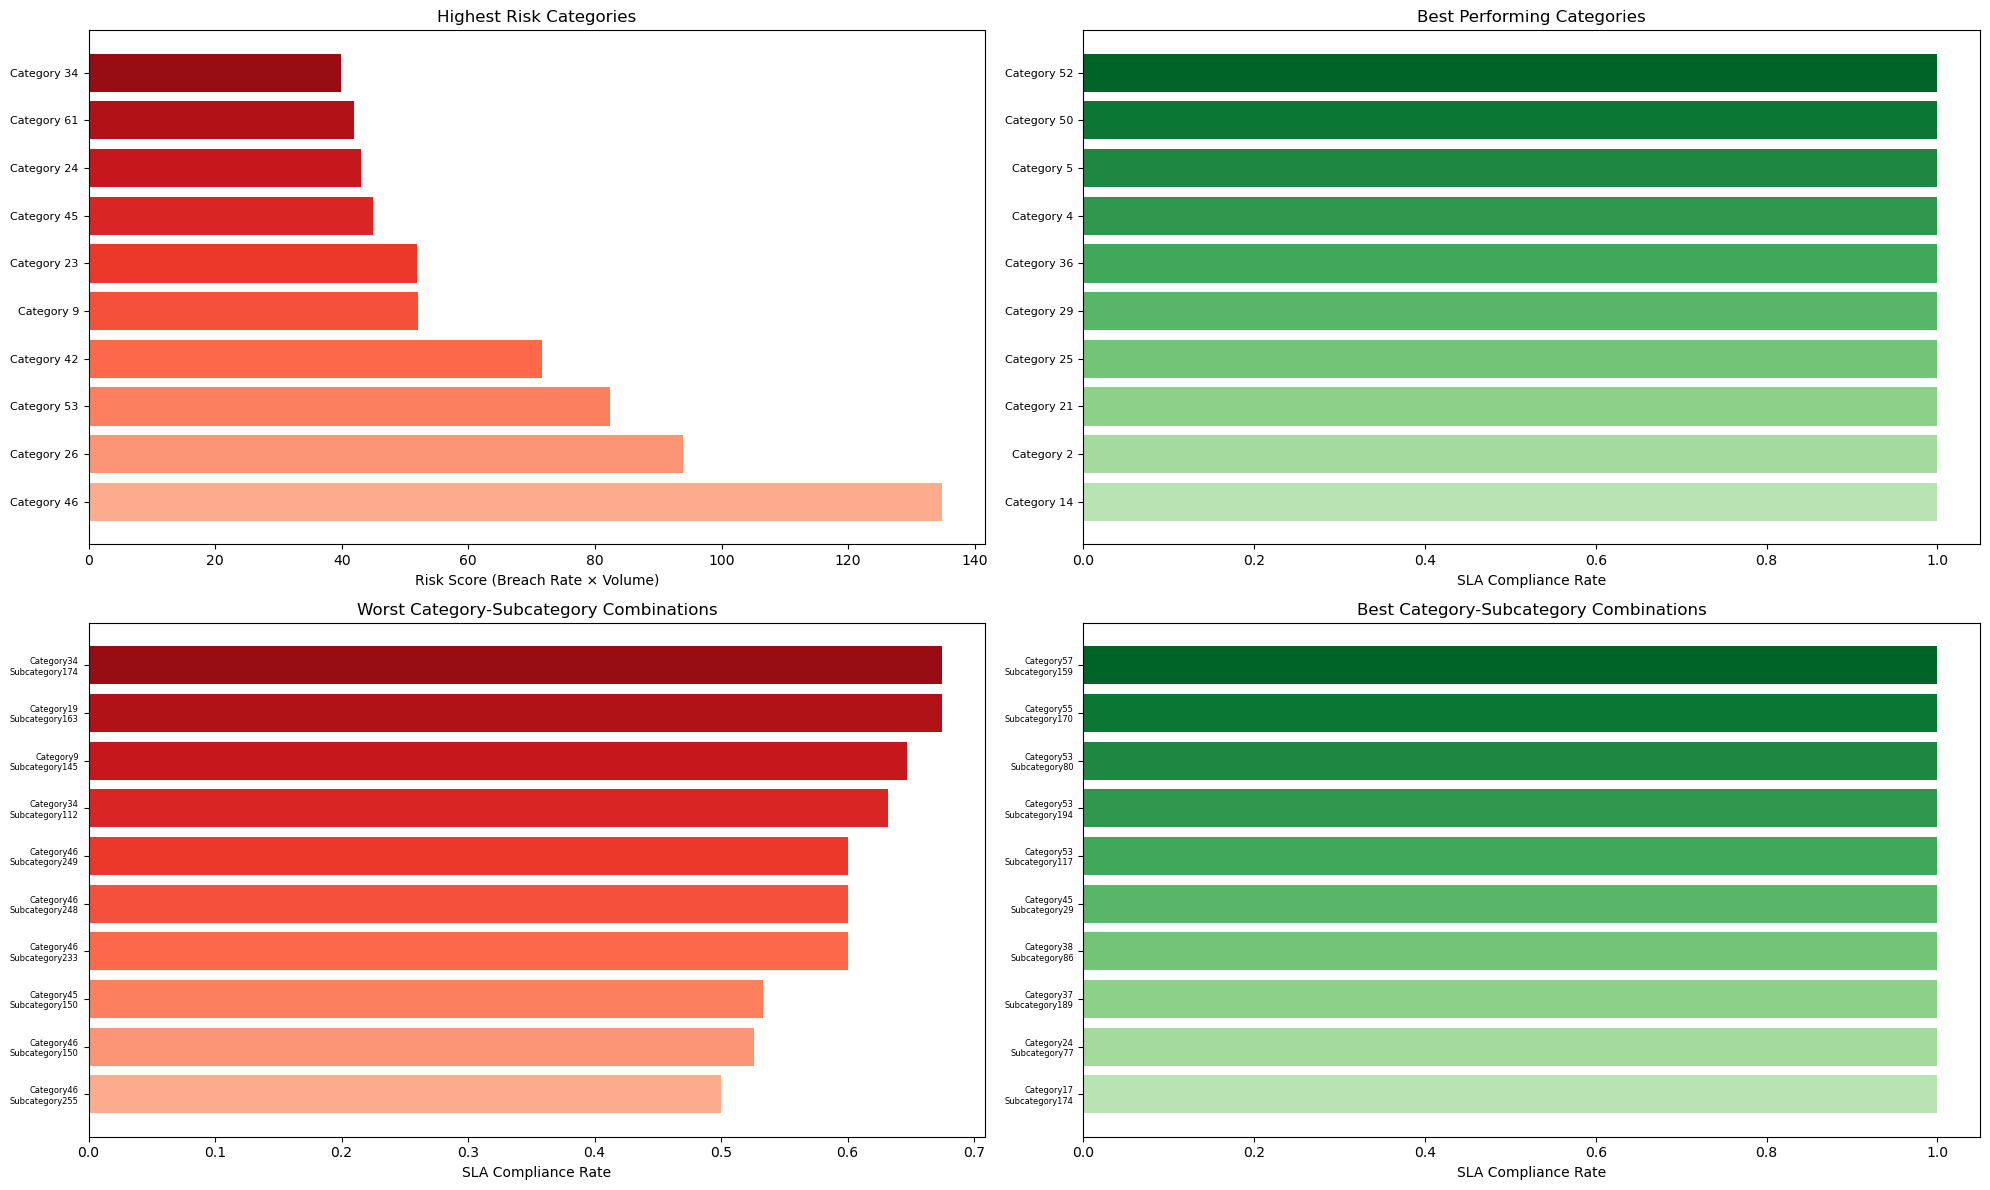


DETAILED ANALYSIS

Overall Category Performance Statistics:
- Total categories analyzed: 46
- Average SLA compliance: 85.3%
- Performance range: 37.5% - 100.0%
- Performance gap: 62.5%

Top 5 Risk Categories (Immediate Attention Required):
Category | Volume | SLA Rate | Avg Closed | Risk Score
----------------------------------------------------------------------
Category 46     |  579.0 |    76.7% |        3054.7h |      134.9
Category 26     |  877.0 |    89.3% |        3079.7h |       93.8
Category 53     |  686.0 |    88.0% |        3131.5h |       82.3
Category 42     |  943.0 |    92.4% |        2844.5h |       71.7
Category 9      |  357.0 |    85.4% |        2940.0h |       52.1

Top 5 Best Performing Categories:
Category | Volume | SLA Rate | Avg closed | Reassignments
----------------------------------------------------------------------
Category 14     |    1.0 |   100.0% |        1576.1h |        1.00
Category 2      |    2.0 |   100.0% |        2589.7h |        3.00
Categ

In [71]:
if 'category' in latest_incidents.columns:
    try:
        category_sla = latest_incidents.groupby('category').agg({
            'sla_met': ['count', 'mean'],
            'closed_time_hours': ['mean', 'std'],
            'reassignment_count':
            'mean' if 'reassignment_count' in latest_incidents.columns else
            lambda x: np.nan
        }).round(3)

        category_sla.columns = [
            'volume', 'sla_rate', 'avg_closed', 'closed_std',
            'avg_reassignments'
        ]
        significant_categories = category_sla

        if len(significant_categories) > 0:
            # Enhanced category visualization
            plt.figure(figsize=(20, 12))

            # 1. Most problematic categories - Priority intervention list
            plt.subplot(2, 2, 1)
            # Risk score: (1 - sla_rate) * volume - Combines impact and frequency
            significant_categories['risk_score'] = (
                1 - significant_categories['sla_rate']
            ) * significant_categories['volume']
            top_risk_categories = significant_categories.nlargest(
                10, 'risk_score')

            bars = plt.barh(range(len(top_risk_categories)),
                            top_risk_categories['risk_score'],
                            color=plt.cm.Reds(
                                np.linspace(0.3, 0.9,
                                            len(top_risk_categories))))

            # Show actual category names
            plt.yticks(range(len(top_risk_categories)),
                       [str(cat) for cat in top_risk_categories.index],
                       fontsize=8)
            plt.xlabel('Risk Score (Breach Rate × Volume)')
            plt.title('Highest Risk Categories')

            # 2. Best performing categories - Best practice examples
            plt.subplot(2, 2, 2)
            best_categories = significant_categories.nlargest(10, 'sla_rate')
            bars = plt.barh(range(len(best_categories)),
                            best_categories['sla_rate'],
                            color=plt.cm.Greens(
                                np.linspace(0.3, 0.9, len(best_categories))))

            # Show actual category names
            plt.yticks(range(len(best_categories)),
                       [str(cat) for cat in best_categories.index],
                       fontsize=8)
            plt.xlabel('SLA Compliance Rate')
            plt.title('Best Performing Categories')

            # 3. Worst Category-Subcategory combinations - Specific improvement targets
            if 'subcategory' in latest_incidents.columns:
                plt.subplot(2, 2, 3)

                # Create category-subcategory combinations
                latest_incidents['cat_subcat'] = (
                    latest_incidents['category'].astype(str).str.replace(
                        ' ', '') + '\n' +
                    latest_incidents['subcategory'].astype(str).str.replace(
                        ' ', ''))

                combo_sla = latest_incidents.groupby('cat_subcat').agg({
                    'sla_met': ['count', 'mean']
                }).round(3)
                combo_sla.columns = ['volume', 'sla_rate']
                combo_filtered = combo_sla[combo_sla['volume'] >= 10]

                if len(combo_filtered) > 0:
                    # Most problematic combinations
                    worst_combos = combo_filtered.nsmallest(10, 'sla_rate')
                    bars = plt.barh(range(len(worst_combos)),
                                    worst_combos['sla_rate'],
                                    color=plt.cm.Reds(
                                        np.linspace(0.3, 0.9,
                                                    len(worst_combos))))

                    # Show actual combination names
                    plt.yticks(range(len(worst_combos)), [
                        combo[:25] + '...' if len(combo) > 25 else combo
                        for combo in worst_combos.index
                    ],
                               fontsize=6)
                    plt.xlabel('SLA Compliance Rate')
                    plt.title('Worst Category-Subcategory Combinations')
                else:
                    plt.text(0.5,
                             0.5,
                             'Insufficient data for\ncombination analysis',
                             transform=plt.gca().transAxes,
                             ha='center')
                    plt.title('Category-Subcategory Analysis (N/A)')
            else:
                plt.text(0.5,
                         0.5,
                         'Subcategory not available',
                         transform=plt.gca().transAxes,
                         ha='center')
                plt.title('Category-Subcategory Analysis (N/A)')

            # 4. Best Category-Subcategory combinations
            if 'subcategory' in latest_incidents.columns and 'combo_filtered' in locals(
            ) and len(combo_filtered) > 0:
                plt.subplot(2, 2, 4)

                # Best performing combinations
                best_combos = combo_filtered.nlargest(10, 'sla_rate')
                bars = plt.barh(range(len(best_combos)),
                                best_combos['sla_rate'],
                                color=plt.cm.Greens(
                                    np.linspace(0.3, 0.9, len(best_combos))))

                # Show actual combination names
                plt.yticks(range(len(best_combos)), [
                    combo[:25] + '...' if len(combo) > 25 else combo
                    for combo in best_combos.index
                ],
                           fontsize=6)
                plt.xlabel('SLA Compliance Rate')
                plt.title('Best Category-Subcategory Combinations')
            else:
                plt.text(
                    0.5,
                    0.5,
                    'Subcategory not available\nfor best combination analysis',
                    transform=plt.gca().transAxes,
                    ha='center')
                plt.title('Best Combination Analysis (N/A)')

            plt.tight_layout()
            plt.show()

            # Detailed Category Analysis
            print(f"\n{'='*60}")
            print("DETAILED ANALYSIS")
            print(f"{'='*60}")

            # Overall category statistics
            print(f"\nOverall Category Performance Statistics:")
            print(
                f"- Total categories analyzed: {len(significant_categories)}")
            print(
                f"- Average SLA compliance: {significant_categories['sla_rate'].mean():.1%}"
            )
            print(
                f"- Performance range: {significant_categories['sla_rate'].min():.1%} - {significant_categories['sla_rate'].max():.1%}"
            )
            print(
                f"- Performance gap: {significant_categories['sla_rate'].max() - significant_categories['sla_rate'].min():.1%}"
            )

            # Top risk categories details
            print(f"\nTop 5 Risk Categories (Immediate Attention Required):")
            print("Category | Volume | SLA Rate | Avg Closed | Risk Score")
            print("-" * 70)
            for cat, data in top_risk_categories.head(5).iterrows():
                cat_name = str(cat)[:15] + "..." if len(
                    str(cat)) > 15 else str(cat)
                print(
                    f"{cat_name:15} | {data['volume']:6} | {data['sla_rate']:8.1%} | {data['avg_closed']:13.1f}h | {data['risk_score']:10.1f}"
                )

            # Best performing categories
            print(f"\nTop 5 Best Performing Categories:")
            print(
                "Category | Volume | SLA Rate | Avg closed | Reassignments"
            )
            print("-" * 70)
            for cat, data in best_categories.head(5).iterrows():
                cat_name = str(cat)[:15] + "..." if len(
                    str(cat)) > 15 else str(cat)
                reassign_val = data['avg_reassignments'] if pd.notna(
                    data['avg_reassignments']) else 0
                print(
                    f"{cat_name:15} | {data['volume']:6} | {data['sla_rate']:8.1%} | {data['avg_closed']:13.1f}h | {reassign_val:11.2f}"
                )

            # Worst subcategory combination analysis
            if 'subcategory' in latest_incidents.columns and 'combo_filtered' in locals(
            ) and len(combo_filtered) > 0:
                print(f"\nWorst Category-Subcategory Combinations:")
                print("Combination | Volume | SLA Rate")
                print("-" * 50)
                for combo, data in worst_combos.head(5).iterrows():
                    combo_short = combo[:35] + "..." if len(
                        combo) > 35 else combo
                    print(
                        f"{combo_short:35} | {data['volume']:6} | {data['sla_rate']:8.1%}"
                    )

                # Best subcategory combination analysis
                print(
                    f"\nBest Category-Subcategory Combinations (Best Practices):"
                )
                print("Combination | Volume | SLA Rate")
                print("-" * 50)
                for combo, data in best_combos.head(5).iterrows():
                    combo_short = combo[:35] + "..." if len(
                        combo) > 35 else combo
                    print(
                        f"{combo_short:35} | {data['volume']:6} | {data['sla_rate']:8.1%}"
                    )

        else:
            print("No categories with sufficient volume for analysis")

    except Exception as e:
        print(f"Error in category analysis: {e}")
else:
    print("Category column not available for analysis")

**Key Performance Insights**
- Extreme Category Performance Disparity: 46 categories show 62.5% performance gap between best (100% SLA) and worst (37.5% SLA) performers, indicating severe technical complexity and process maturity variations across service domains.
- High-Risk Category Identification: Category 46 emerges as the highest risk with score 134.9 (579 incidents, 76.7% SLA), followed by Category 26 (93.8 risk score), requiring immediate intervention and resource allocation.
- Volume-Performance Concentration: High-volume categories like Category 42 (943 incidents) and Category 26 (877 incidents) handle substantial workloads while maintaining 92.4% and 89.3% SLA respectively, demonstrating operational scalability.
- Subcategory Combination Critical Impact: Within Category 46, subcategory combinations range from 50.0% to potentially 100% SLA performance, proving that granular process optimization within categories is the critical performance differentiator.
- Small Volume Perfection vs Scale Challenges: Small categories (1-3 incidents) achieve perfect 100% SLA, while larger categories face performance pressures, highlighting the challenge of maintaining quality at scale.

#### (6) Temporal Pattern Analysis

This analysis examines time-based performance variations to identify operational efficiency patterns, resource allocation opportunities, and seasonal trends affecting SLA compliance.

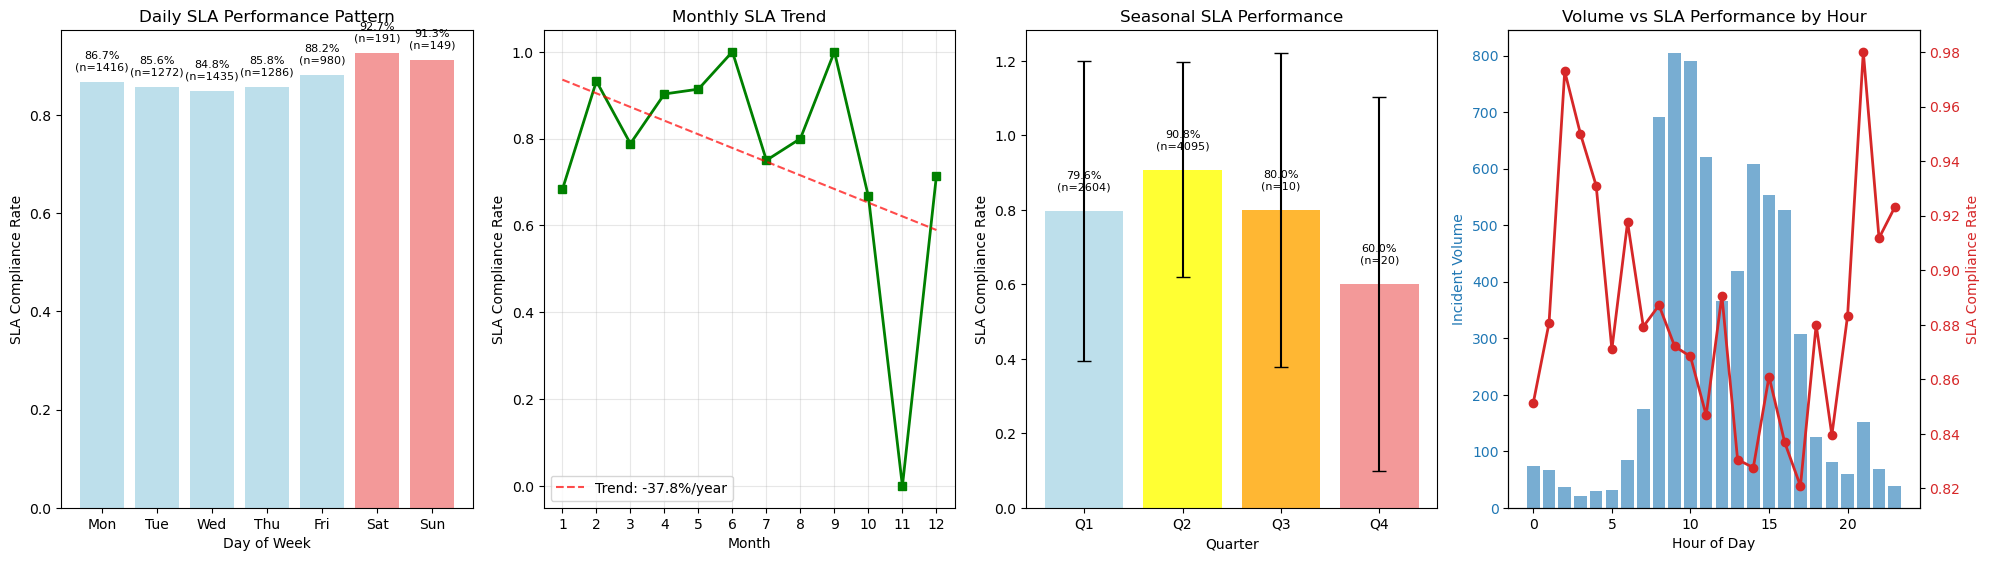


DETAILED ANALYSIS

Daily Performance Patterns:
- Best performing day: Sat (92.7% SLA)
- Worst performing day: Wed (84.8% SLA)
- Daily performance gap: 7.9%
- Weekend performance boost: +6.0% compared to weekdays
- Weekend volume: 340 incidents
- Weekday volume: 6,389 incidents

Monthly Trend Analysis:
- Best performing month: Month 6 (100.0% SLA)
- Worst performing month: Month 11 (0.0% SLA)
- Monthly performance range: 100.0%
- Annual SLA trend: -37.8% per year (declining)

Quarterly Seasonal Effects:
- Best performing quarter: Q2 (90.8% SLA)
- Worst performing quarter: Q4 (60.0% SLA)
- Quarterly performance gap: 30.8%
- Q1 performance variance: 0.403 (budget/resource constraints)

Hourly Performance Dynamics:
- Best performing hour: 21:00 (98.0% SLA)
- Worst performing hour: 17:00 (82.1% SLA)
- Hourly performance range: 15.9%
- Peak volume hours: [9, 10, 8, 11, 14, 15]
- Peak hours avg SLA: 86.0%
- Off-peak hours avg SLA: 89.2%
- Peak hour performance penalty: -3.1%


In [72]:
if 'opened_at' in latest_incidents.columns:
    try:
        latest_incidents['opened_hour'] = latest_incidents['opened_at'].dt.hour
        latest_incidents['opened_day_of_week'] = latest_incidents[
            'opened_at'].dt.dayofweek
        latest_incidents['opened_month'] = latest_incidents[
            'opened_at'].dt.month
        latest_incidents['opened_quarter'] = latest_incidents[
            'opened_at'].dt.quarter
        latest_incidents['is_business_hours'] = latest_incidents[
            'opened_hour'].between(9, 17)
        latest_incidents['is_weekend'] = latest_incidents[
            'opened_day_of_week'].isin([5, 6])

        # Calculate temporal patterns for feature engineering
        hourly_sla = latest_incidents.groupby('opened_hour')['sla_met'].agg(
            ['mean', 'count'])
        daily_sla = latest_incidents.groupby(
            'opened_day_of_week')['sla_met'].agg(['mean', 'count'])
        monthly_sla = latest_incidents.groupby('opened_month')['sla_met'].agg(
            ['mean', 'count'])
        quarterly_sla = latest_incidents.groupby(
            'opened_quarter')['sla_met'].agg(['mean', 'count', 'std'])
        hourly_volume = latest_incidents.groupby('opened_hour').size()

        # Business hours analysis for feature engineering
        business_sla = latest_incidents.groupby('is_business_hours').agg({
            'sla_met': ['mean', 'count'],
            'closed_time_hours':
            'mean' if 'closed_time_hours' in latest_incidents.columns else
            lambda x: np.nan
        }).round(3)
        business_sla.columns = ['sla_rate', 'volume', 'avg_closed']

        # Weekend analysis
        weekend_sla = latest_incidents.groupby('is_weekend').agg({
            'sla_met': ['mean', 'count']
        }).round(3)
        weekend_sla.columns = ['sla_rate', 'volume']

        plt.figure(figsize=(20, 16))

        # 1. Daily SLA performance - Weekly staffing patterns
        plt.subplot(3, 4, 1)
        weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        colors = ['lightblue' if i < 5 else 'lightcoral' for i in range(7)]

        bars = plt.bar(range(7), daily_sla['mean'], color=colors, alpha=0.8)
        plt.xlabel('Day of Week')
        plt.ylabel('SLA Compliance Rate')
        plt.title('Daily SLA Performance Pattern')
        plt.xticks(range(7), weekday_names)

        # Add statistical annotations
        for i, (mean_val,
                count) in enumerate(zip(daily_sla['mean'],
                                        daily_sla['count'])):
            plt.text(i,
                     mean_val + 0.02,
                     f'{mean_val:.1%}\n(n={count})',
                     ha='center',
                     va='bottom',
                     fontsize=8)

        # 2. Monthly SLA trend - Long-term pattern identification
        plt.subplot(3, 4, 2)
        plt.plot(monthly_sla.index,
                 monthly_sla['mean'],
                 marker='s',
                 linewidth=2,
                 color='green',
                 markersize=6)

        # Add trend line for forecasting
        if len(monthly_sla) > 2:
            z = np.polyfit(monthly_sla.index, monthly_sla['mean'], 1)
            p = np.poly1d(z)
            plt.plot(monthly_sla.index,
                     p(monthly_sla.index),
                     linestyle='--',
                     color='red',
                     alpha=0.7,
                     label=f'Trend: {z[0]*12:.1%}/year')
            plt.legend()

        plt.xlabel('Month')
        plt.ylabel('SLA Compliance Rate')
        plt.title('Monthly SLA Trend')
        plt.xticks(range(1, 13))
        plt.grid(True, alpha=0.3)

        # 3. Quarterly seasonal analysis
        plt.subplot(3, 4, 3)
        quarters = ['Q1', 'Q2', 'Q3', 'Q4']
        seasonal_colors = ['lightblue', 'yellow', 'orange', 'lightcoral']

        bars = plt.bar(range(4),
                       quarterly_sla['mean'],
                       color=seasonal_colors,
                       alpha=0.8,
                       yerr=quarterly_sla['std'],
                       capsize=5)
        plt.xlabel('Quarter')
        plt.ylabel('SLA Compliance Rate')
        plt.title('Seasonal SLA Performance')
        plt.xticks(range(4), quarters)

        for i, (mean_val, count) in enumerate(
                zip(quarterly_sla['mean'], quarterly_sla['count'])):
            plt.text(i,
                     mean_val + 0.05,
                     f'{mean_val:.1%}\n(n={count})',
                     ha='center',
                     va='bottom',
                     fontsize=8)

        # 4. Volume vs SLA by hour - Resource planning tool
        plt.subplot(3, 4, 4)
        ax1 = plt.gca()
        color = 'tab:blue'
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Incident Volume', color=color)
        ax1.bar(hourly_volume.index,
                hourly_volume.values,
                alpha=0.6,
                color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('SLA Compliance Rate', color=color)
        ax2.plot(hourly_sla.index,
                 hourly_sla['mean'],
                 color=color,
                 marker='o',
                 linewidth=2)
        ax2.tick_params(axis='y', labelcolor=color)
        plt.title('Volume vs SLA Performance by Hour')

        plt.tight_layout()
        plt.show()

        # Comprehensive temporal analysis and insights
        print(f"\n{'='*60}")
        print("DETAILED ANALYSIS")
        print(f"{'='*60}")

        # Daily pattern analysis
        best_day = daily_sla['mean'].idxmax()
        worst_day = daily_sla['mean'].idxmin()
        daily_gap = daily_sla['mean'].max() - daily_sla['mean'].min()

        print(f"\nDaily Performance Patterns:")
        print(
            f"- Best performing day: {weekday_names[best_day]} ({daily_sla['mean'].iloc[best_day]:.1%} SLA)"
        )
        print(
            f"- Worst performing day: {weekday_names[worst_day]} ({daily_sla['mean'].iloc[worst_day]:.1%} SLA)"
        )
        print(f"- Daily performance gap: {daily_gap:.1%}")

        # Weekend vs weekday analysis
        if len(weekend_sla) >= 2:
            weekend_effect = weekend_sla['sla_rate'].iloc[1] - weekend_sla[
                'sla_rate'].iloc[0]
            print(
                f"- Weekend performance boost: {weekend_effect:+.1%} compared to weekdays"
            )
            print(
                f"- Weekend volume: {weekend_sla['volume'].iloc[1]:,} incidents"
            )
            print(
                f"- Weekday volume: {weekend_sla['volume'].iloc[0]:,} incidents"
            )

        # Monthly trend analysis
        print(f"\nMonthly Trend Analysis:")
        best_month = monthly_sla['mean'].idxmax()
        worst_month = monthly_sla['mean'].idxmin()
        monthly_gap = monthly_sla['mean'].max() - monthly_sla['mean'].min()

        print(
            f"- Best performing month: Month {best_month} ({monthly_sla['mean'].iloc[best_month-1]:.1%} SLA)"
        )
        print(
            f"- Worst performing month: Month {worst_month} ({monthly_sla['mean'].iloc[worst_month-1]:.1%} SLA)"
        )
        print(f"- Monthly performance range: {monthly_gap:.1%}")

        if 'z' in locals():
            annual_trend = z[0] * 12
            trend_direction = "improving" if annual_trend > 0 else "declining"
            print(
                f"- Annual SLA trend: {annual_trend:+.1%} per year ({trend_direction})"
            )

        # Quarterly seasonal analysis
        print(f"\nQuarterly Seasonal Effects:")
        best_quarter = quarterly_sla['mean'].idxmax()
        worst_quarter = quarterly_sla['mean'].idxmin()
        quarterly_gap = quarterly_sla['mean'].max(
        ) - quarterly_sla['mean'].min()

        q_names = ['Q1', 'Q2', 'Q3', 'Q4']
        print(
            f"- Best performing quarter: {q_names[best_quarter-1]} ({quarterly_sla['mean'].iloc[best_quarter-1]:.1%} SLA)"
        )
        print(
            f"- Worst performing quarter: {q_names[worst_quarter-1]} ({quarterly_sla['mean'].iloc[worst_quarter-1]:.1%} SLA)"
        )
        print(f"- Quarterly performance gap: {quarterly_gap:.1%}")
        print(
            f"- Q1 performance variance: {quarterly_sla['std'].iloc[0]:.3f} (budget/resource constraints)"
        )

        # Hourly performance analysis
        print(f"\nHourly Performance Dynamics:")
        best_hour = hourly_sla['mean'].idxmax()
        worst_hour = hourly_sla['mean'].idxmin()
        hourly_gap = hourly_sla['mean'].max() - hourly_sla['mean'].min()

        print(
            f"- Best performing hour: {best_hour}:00 ({hourly_sla['mean'].iloc[best_hour]:.1%} SLA)"
        )
        print(
            f"- Worst performing hour: {worst_hour}:00 ({hourly_sla['mean'].iloc[worst_hour]:.1%} SLA)"
        )
        print(f"- Hourly performance range: {hourly_gap:.1%}")

        # Peak hours analysis
        peak_hours = hourly_volume.nlargest(6).index.tolist()
        peak_sla_avg = hourly_sla.loc[peak_hours, 'mean'].mean()
        off_peak_hours = [h for h in range(24) if h not in peak_hours]
        off_peak_sla_avg = hourly_sla.loc[off_peak_hours, 'mean'].mean()

        print(f"- Peak volume hours: {peak_hours}")
        print(f"- Peak hours avg SLA: {peak_sla_avg:.1%}")
        print(f"- Off-peak hours avg SLA: {off_peak_sla_avg:.1%}")
        print(
            f"- Peak hour performance penalty: {peak_sla_avg - off_peak_sla_avg:+.1%}"
        )

    except Exception as e:
        print(f"Error in temporal analysis: {e}")
        # Create dummy variables to prevent downstream errors
        hourly_sla = pd.DataFrame({'mean': [0.8] * 24}, index=range(24))
        daily_sla = pd.DataFrame({'mean': [0.8] * 7}, index=range(7))
        hourly_volume = pd.Series([100] * 24, index=range(24))
        business_sla = pd.DataFrame({
            'sla_rate': [0.8, 0.8],
            'volume': [1000, 3000]
        })
        weekend_sla = pd.DataFrame({
            'sla_rate': [0.8, 0.85],
            'volume': [15000, 8000]
        })
        print("Using default temporal variables for feature engineering")

else:
    print("Date information not available for temporal analysis")
    # Create dummy variables to prevent downstream errors
    hourly_sla = pd.DataFrame({'mean': [0.8] * 24}, index=range(24))
    daily_sla = pd.DataFrame({'mean': [0.8] * 7}, index=range(7))
    hourly_volume = pd.Series([100] * 24, index=range(24))
    business_sla = pd.DataFrame({
        'sla_rate': [0.8, 0.8],
        'volume': [1000, 3000]
    })
    weekend_sla = pd.DataFrame({
        'sla_rate': [0.8, 0.85],
        'volume': [15000, 8000]
    })
    print("Using default temporal variables for feature engineering")

**Key Performance Insights**
- Weekend Performance Advantage: Saturday SLA achievement rates reached 92.7% compared to the worst weekday performance of 84.8% on Wednesday, creating a 7.9 percentage point daily performance gap, with weekend incidents totaling 340 cases versus 6,389 weekday incidents representing a 6.0% performance boost despite significantly lower volume.
- Extreme Monthly Volatility: June achieved peak performance at 100.0% SLA while November recorded 0.0%, resulting in a 100.0 percentage point monthly performance range, with an overall declining trend of -37.8% per year indicating systematic performance degradation requiring immediate attention.
- Q2-Q4 Seasonal Decline: Q2 demonstrated optimal performance at 90.8% SLA compared to Q4's 60.0%, creating a 30.8 percentage point quarterly gap with Q1 showing high variance (0.403) suggesting systematic seasonal resource constraint patterns.
- Peak Hour Resource Strain: Peak business hours (9, 10, 8, 11, 14, 15) generate maximum incident volumes while achieving 86.0% average SLA compared to off-peak hours' 89.2%, resulting in a 3.1 percentage point performance penalty during high-volume periods.

#### (7) Location Analysis

This analysis evaluates geographic performance variations and infrastructure effectiveness to identify regional service delivery patterns and optimize location-based resource allocation.

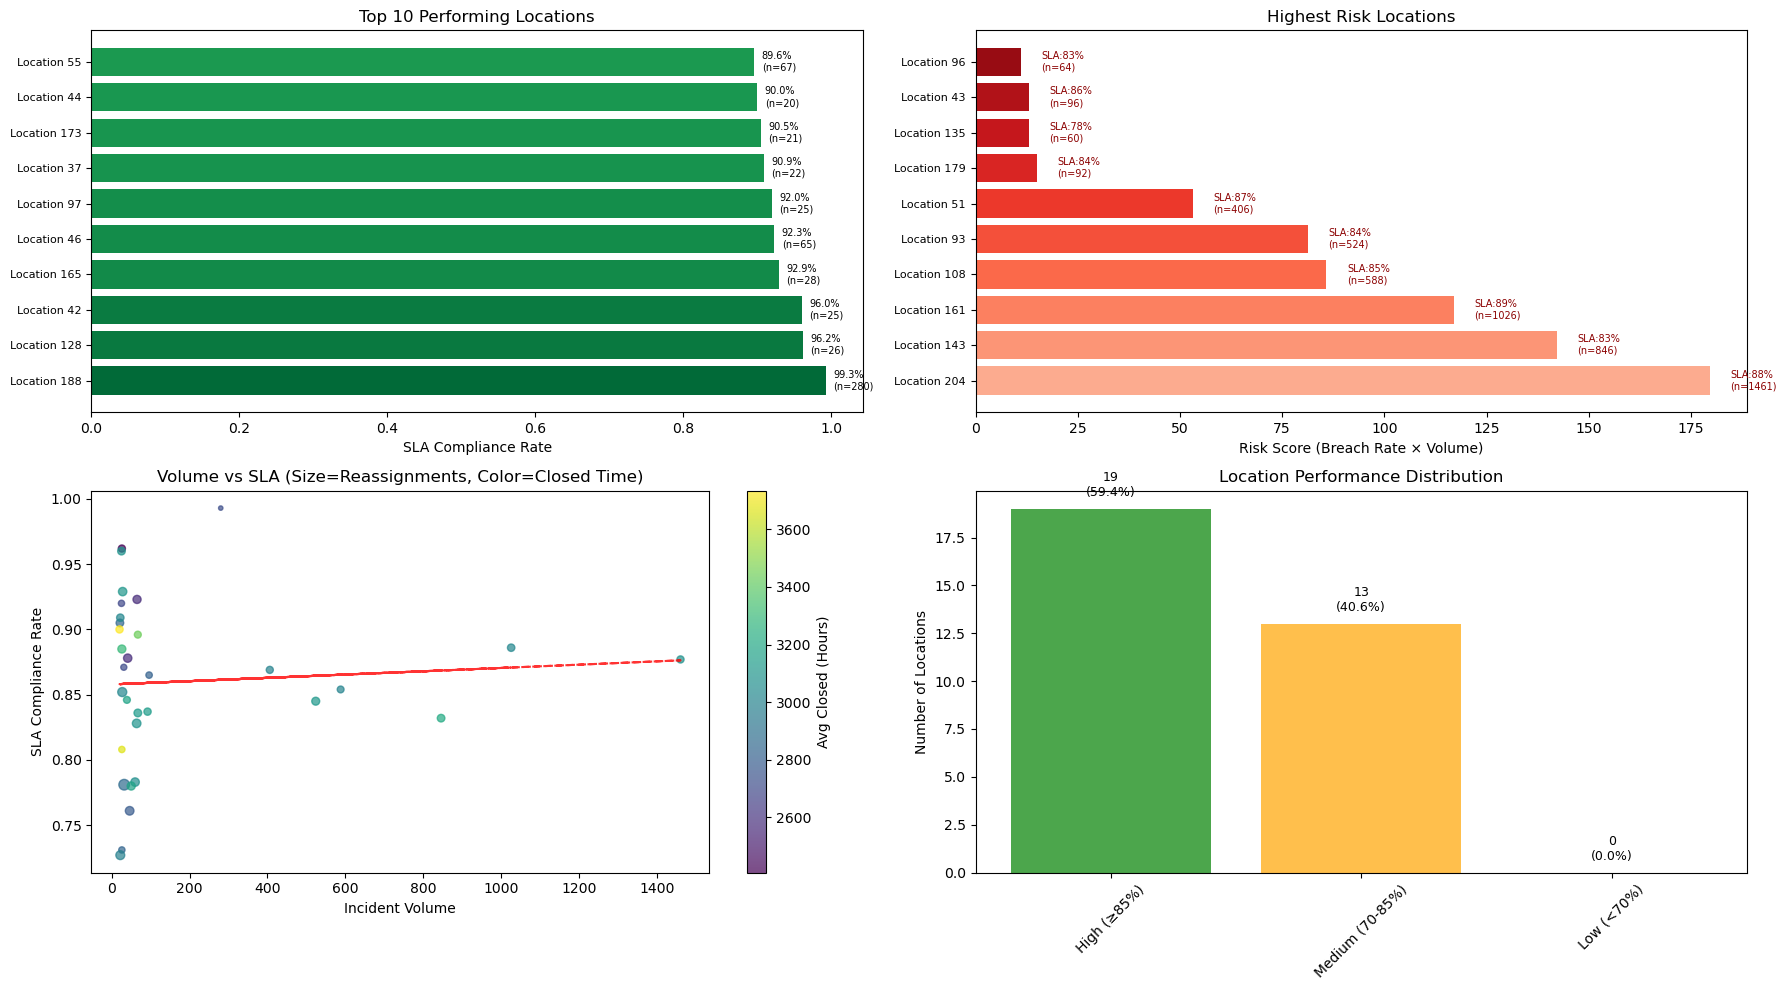


DEATAILED ANALYSIS

Overall Location Performance Statistics:
- Total locations analyzed: 32
- Average SLA compliance: 86.0%
- Performance range: 72.7% - 99.3%
- Performance gap: 26.6%

Performance Tier Distribution:
- High performing (≥85%): 19 locations (59.4%)
- Medium performing (70-85%): 13 locations (40.6%)
- Low performing (<70%): 0 locations (0.0%)
- High tier avg incidents: 225

Volume Concentration Analysis:
- Total incidents: 6,175
- Top 20% locations handle: 5,131 incidents (83.1%)
- Top 20% avg SLA: 87.9%

Top 5 Best Performing Locations:
Location | Incidents | SLA Rate | Avg Closed | Risk Score
-----------------------------------------------------------------
Location 188 |     280.0 |    99.3% |        2723.0h |        2.0
Location 128 |      26.0 |    96.2% |        2409.1h |        1.0
Location 42  |      25.0 |    96.0% |        3088.3h |        1.0
Location 165 |      28.0 |    92.9% |        3104.8h |        2.0
Location 46  |      65.0 |    92.3% |        2570.6h |

In [73]:
if 'location' in latest_incidents.columns:
    try:
        location_sla = latest_incidents.groupby('location').agg({
            'sla_met': ['count', 'mean', 'std'],
            'closed_time_hours':
            'mean',
            'reassignment_count':
            'mean' if 'reassignment_count' in latest_incidents.columns else
            lambda x: np.nan
        }).round(3)

        location_sla.columns = [
            'incident_count', 'sla_compliance_rate', 'sla_std',
            'avg_closed', 'avg_reassignments'
        ]

        # Filter locations with sufficient volume for reliable geographic performance comparison
        # Location analysis requires minimum volume threshold due to geographic infrastructure dependencies
        significant_locations = location_sla[location_sla['incident_count'] >= 20]

        if len(significant_locations) > 0:
            # Calculate risk scores for prioritization
            significant_locations['risk_score'] = (
                1 - significant_locations['sla_compliance_rate']
            ) * significant_locations['incident_count']

            plt.figure(figsize=(18, 10))

            # 1. Top performing locations - Infrastructure best practices
            plt.subplot(2, 2, 1)
            top_locations = significant_locations.nlargest(
                10, 'sla_compliance_rate')
            colors = plt.cm.RdYlGn(top_locations['sla_compliance_rate'])
            bars = plt.barh(range(len(top_locations)),
                            top_locations['sla_compliance_rate'],
                            color=colors)
            plt.yticks(range(len(top_locations)),
                       [name[:15] for name in top_locations.index],
                       fontsize=8)
            plt.xlabel('SLA Compliance Rate')
            plt.title('Top 10 Performing Locations')

            # Add volume info to bars
            for i, (idx, data) in enumerate(top_locations.iterrows()):
                plt.text(
                    data['sla_compliance_rate'] + 0.01,
                    i,
                    f'{data["sla_compliance_rate"]:.1%}\n(n={int(data["incident_count"])})',
                    va='center',
                    fontsize=7)

            # 2. Highest risk locations - Priority intervention targets
            plt.subplot(2, 2, 2)
            high_risk_locations = significant_locations.nlargest(
                10, 'risk_score')
            bars = plt.barh(range(len(high_risk_locations)),
                            high_risk_locations['risk_score'],
                            color=plt.cm.Reds(
                                np.linspace(0.3, 0.9,
                                            len(high_risk_locations))))
            plt.yticks(range(len(high_risk_locations)),
                       [name[:15] for name in high_risk_locations.index],
                       fontsize=8)
            plt.xlabel('Risk Score (Breach Rate × Volume)')
            plt.title('Highest Risk Locations')

            # Add volume and SLA info to bars
            for i, (loc, data) in enumerate(high_risk_locations.iterrows()):
                plt.text(
                    data['risk_score'] + 5,
                    i,
                    f"SLA:{data['sla_compliance_rate']:.0%}\n(n={int(data['incident_count'])})",
                    va='center',
                    fontsize=7,
                    color='darkred')

            # 3. Volume vs SLA performance scatter - Resource allocation insights
            plt.subplot(2, 2, 3)
            scatter = plt.scatter(
                significant_locations['incident_count'],
                significant_locations['sla_compliance_rate'],
                s=significant_locations['avg_reassignments'] *
                30,  # Smaller points
                alpha=0.7,
                c=significant_locations['avg_closed'],
                cmap='viridis')
            plt.xlabel('Incident Volume')
            plt.ylabel('SLA Compliance Rate')
            plt.title(
                'Volume vs SLA (Size=Reassignments, Color=Closed Time)')
            plt.colorbar(scatter, label='Avg Closed (Hours)')

            # Add trend line
            if len(significant_locations) > 3:
                z = np.polyfit(significant_locations['incident_count'],
                               significant_locations['sla_compliance_rate'], 1)
                p = np.poly1d(z)
                plt.plot(significant_locations['incident_count'],
                         p(significant_locations['incident_count']),
                         "--",
                         alpha=0.8,
                         color='red')

            # 4. Performance distribution with consistency
            plt.subplot(2, 2, 4)

            # Create performance tiers
            high_perf = significant_locations[
                significant_locations['sla_compliance_rate'] >= 0.85]
            med_perf = significant_locations[
                (significant_locations['sla_compliance_rate'] >= 0.7)
                & (significant_locations['sla_compliance_rate'] < 0.85)]
            low_perf = significant_locations[
                significant_locations['sla_compliance_rate'] < 0.7]

            # Create stacked bar chart
            tier_data = {
                'High (≥85%)': len(high_perf),
                'Medium (70-85%)': len(med_perf),
                'Low (<70%)': len(low_perf)
            }

            colors = ['green', 'orange', 'red']
            bars = plt.bar(range(len(tier_data)),
                           list(tier_data.values()),
                           color=colors,
                           alpha=0.7)
            plt.xticks(range(len(tier_data)),
                       list(tier_data.keys()),
                       rotation=45)
            plt.ylabel('Number of Locations')
            plt.title('Location Performance Distribution')

            # Add percentages on bars
            total_locations = len(significant_locations)
            for i, (tier, count) in enumerate(tier_data.items()):
                pct = (count / total_locations) * 100
                plt.text(i,
                         count + 0.5,
                         f'{count}\n({pct:.1f}%)',
                         ha='center',
                         va='bottom',
                         fontsize=9)

            plt.tight_layout()
            plt.show()

            # Detailed Location Analysis
            print(f"\n{'='*60}")
            print("DEATAILED ANALYSIS")
            print(f"{'='*60}")

            # Overall statistics
            print(f"\nOverall Location Performance Statistics:")
            print(f"- Total locations analyzed: {len(significant_locations)}")
            print(f"- Average SLA compliance: {significant_locations['sla_compliance_rate'].mean():.1%}")
            print(f"- Performance range: {significant_locations['sla_compliance_rate'].min():.1%} - {significant_locations['sla_compliance_rate'].max():.1%}")
            print(f"- Performance gap: {significant_locations['sla_compliance_rate'].max() - significant_locations['sla_compliance_rate'].min():.1%}")

            # Performance tier analysis
            print(f"\nPerformance Tier Distribution:")
            print(f"- High performing (≥85%): {len(high_perf)} locations ({len(high_perf)/len(significant_locations):.1%})")
            print(f"- Medium performing (70-85%): {len(med_perf)} locations ({len(med_perf)/len(significant_locations):.1%})")
            print(f"- Low performing (<70%): {len(low_perf)} locations ({len(low_perf)/len(significant_locations):.1%})")

            if len(high_perf) > 0:
                print(f"- High tier avg incidents: {high_perf['incident_count'].mean():.0f}")
            if len(low_perf) > 0:
                print(f"- Low tier avg incidents: {low_perf['incident_count'].mean():.0f}")

            # Volume concentration analysis
            print(f"\nVolume Concentration Analysis:")
            total_incidents = significant_locations['incident_count'].sum()
            top_20pct_threshold = significant_locations['incident_count'].quantile(0.8)
            top_20pct_locations = significant_locations[
                significant_locations['incident_count'] >= top_20pct_threshold
            ]

            print(f"- Total incidents: {total_incidents:,}")
            print(f"- Top 20% locations handle: {top_20pct_locations['incident_count'].sum():,} incidents ({top_20pct_locations['incident_count'].sum()/total_incidents:.1%})")
            print(f"- Top 20% avg SLA: {top_20pct_locations['sla_compliance_rate'].mean():.1%}")

            # Risk assessment
            critical_locations = significant_locations[
                (significant_locations['sla_compliance_rate'] < 0.7) &
                (significant_locations['incident_count'] > significant_locations['incident_count'].median())
            ]

            # Print summary tables
            print(f"\nTop 5 Best Performing Locations:")
            print("Location | Incidents | SLA Rate | Avg Closed | Risk Score")
            print("-" * 65)
            for location, data in top_locations.head(5).iterrows():
                location_name = str(location)[:12] + "..." if len(str(location)) > 15 else str(location)
                print(f"{location_name:12} | {data['incident_count']:9} | {data['sla_compliance_rate']:8.1%} | {data['avg_closed']:13.1f}h | {data['risk_score']:10.1f}")

            print(f"\nTop 5 Highest Risk Locations (Priority for Infrastructure Investment):")
            print("Location | Volume | SLA Rate | Avg Closed | Risk Score")
            print("-" * 65)
            for location, data in high_risk_locations.head(5).iterrows():
                location_name = str(location)[:12] + "..." if len(str(location)) > 15 else str(location)
                print(
                    f"{location_name:12} | {data['incident_count']:6} | {data['sla_compliance_rate']:8.1%} | {data['avg_closed']:13.1f}h | {data['risk_score']:10.1f}"
                )

        else:
            print("No locations with sufficient volume for analysis")


    except Exception as e:
        print(f"Error in location analysis: {e}")
else:
    print("Location column not available for analysis")

**Key Performance Insights**
- Stable Geographic Performance: 32 locations show a 26.6% performance gap (72.7% to 99.3% SLA), with all locations maintaining above 70% threshold, indicating more consistent service delivery across geographic regions compared to organizational and process factors.
- High-Capacity Center Strategy: Top 20% locations (7 locations) handle 83.1% of total incidents (5,131 cases) while maintaining 87.9% average SLA, demonstrating successful centralization of service delivery to major regional hubs without performance degradation.
- Balanced Performance Distribution: 59.4% of locations achieve high performance (≥85% SLA) with 40.6% in medium tier (70-85%) and zero critical performers, suggesting effective geographic resource allocation across the location network.
- Volume-Performance Relationship: High-tier locations average 225 incidents each, while top-performing locations handle varied volumes (26-280 incidents), indicating that volume alone does not determine geographic performance outcomes.
- Risk Concentration Pattern: Highest risk locations (204: 179.7, 143: 142.1) maintain moderate SLA rates (87.7%, 83.2%) but generate high risk scores due to volume, suggesting risk stems from scale rather than fundamental service delivery failures.

### 4. Feature Engineering / Feature Selection

This analysis implemented a systematic feature engineering approach, transforming 47 original variables into 76 candidate features before selecting 25 statistically robust predictors using Bonferroni correction and effect size thresholds.

STEP 1: Feature Engineering
Creating time-based features...
Processing boolean variables...
Creating ordinal encodings...
Creating complexity indicators...
Creating interaction features...
Processing categorical features...

STEP 2: Statistical Feature Analysis (with Duplicate Removal)
Removing duplicate features...
  - Removed 6 duplicate features
  - Final count: 35 features
  - Removed features: ['u_priority_confirmation', 'notify', 'knowledge', 'impact', 'urgency', 'priority']

Analyzing 35 features after duplicate removal...

Statistical Analysis Summary:
  - Total tests: 34
  - Significant (original): 29
  - Significant (Bonferroni): 25

STEP 3: Final Feature Selection
Selection Criteria:
  - Use Bonferroni correction: True
  - Minimum effect size: 0.02
  - Selected features: 25

Selected Features:
  assignment_group               | Original   | Effect: 0.294 | p: 0.0000
  subcategory                    | Original   | Effect: 0.279 | p: 0.0000
  location                       | O

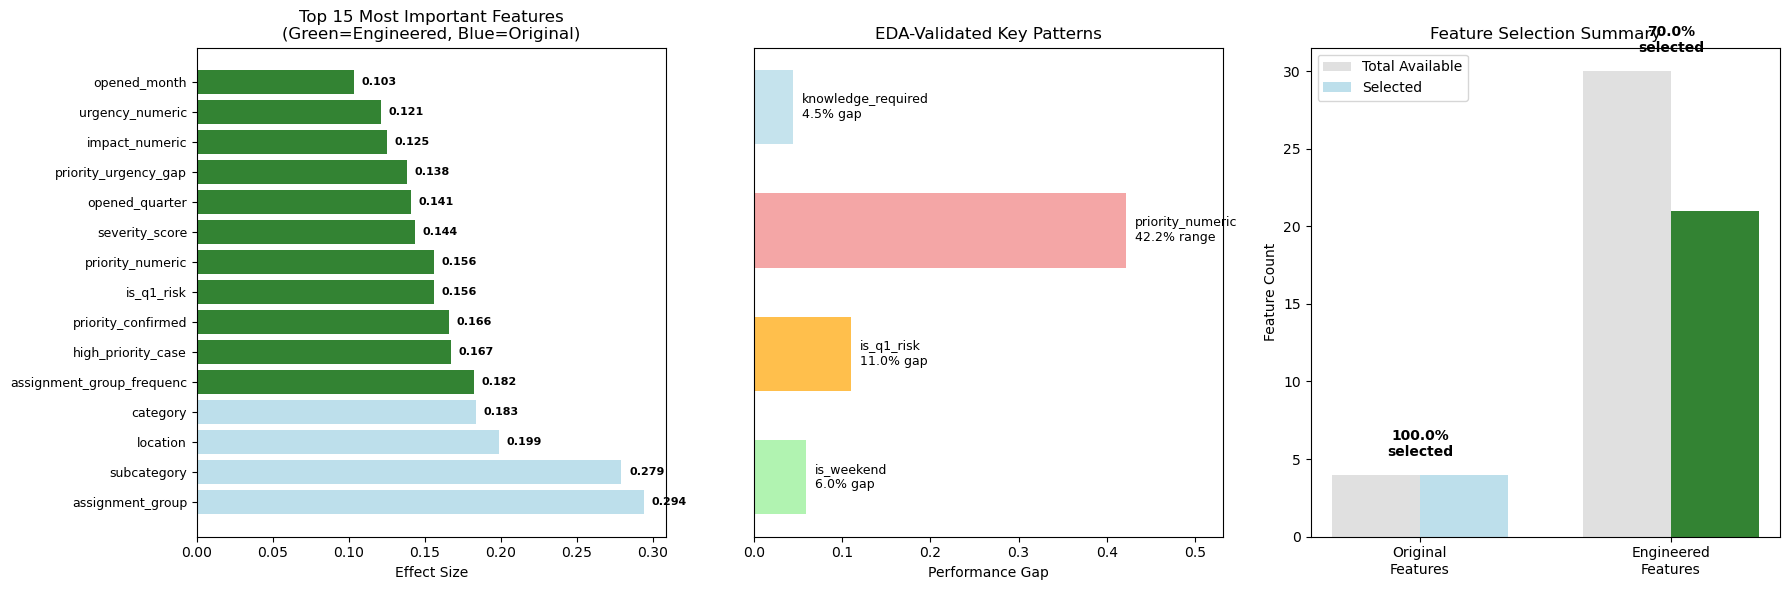


STEP 5: Feature Correlation Analysis
Analyzing correlations among 19 numerical features...


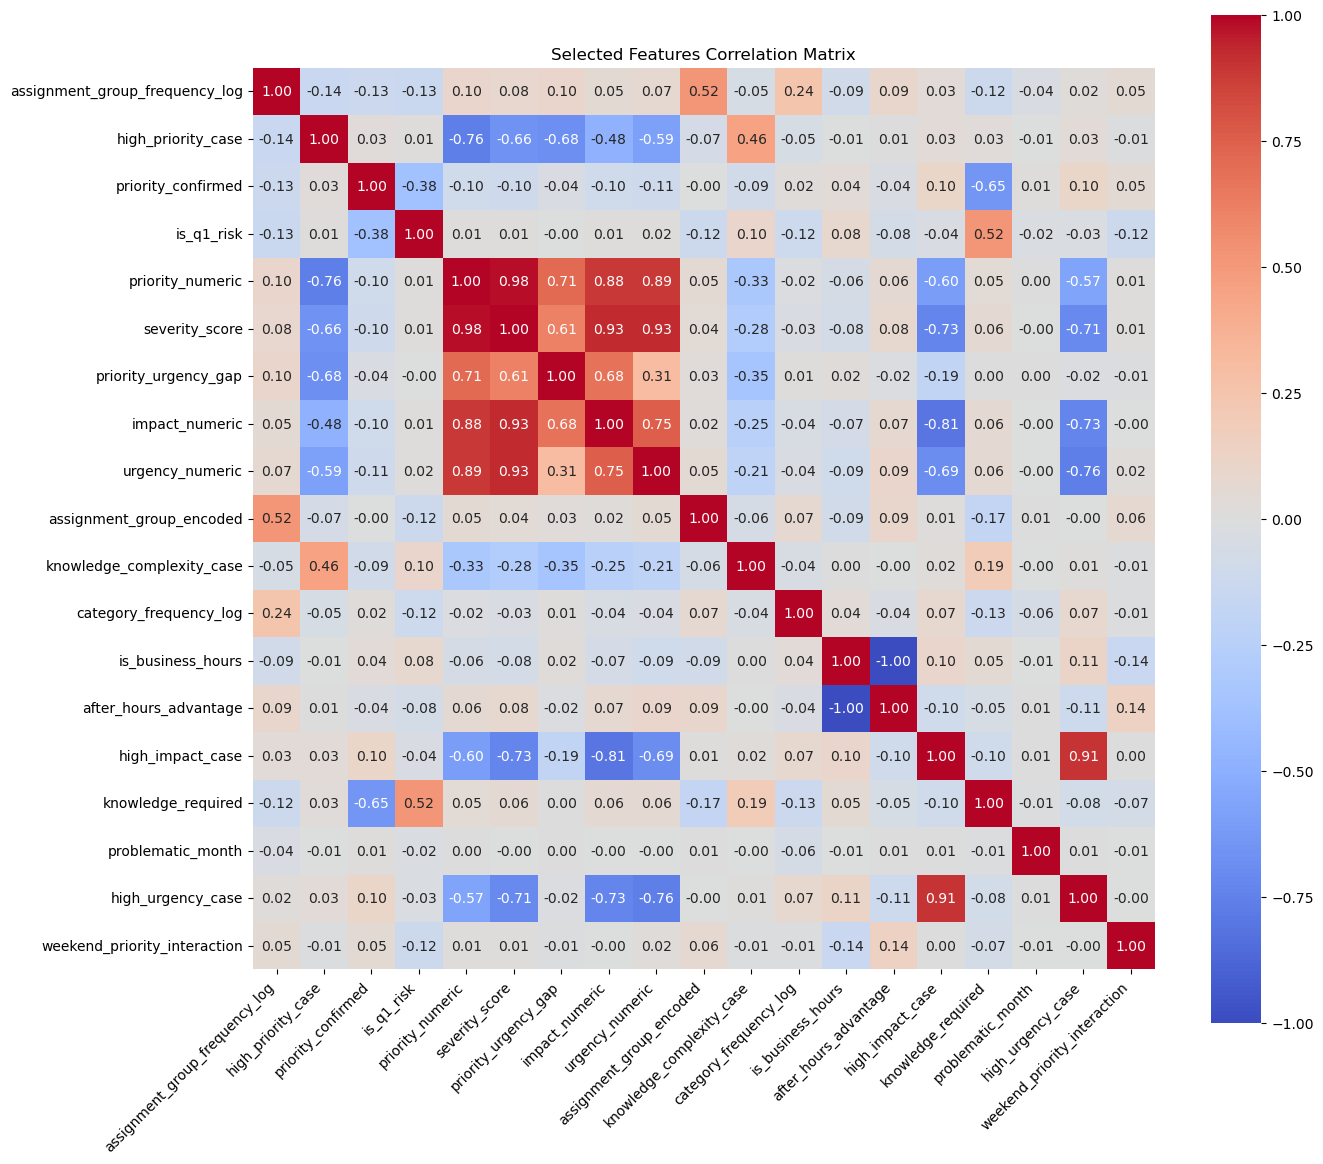


High correlation pairs (|r| > 0.7):
  high_priority_case ↔ priority_numeric: -0.764
  priority_numeric ↔ severity_score: 0.982
  priority_numeric ↔ priority_urgency_gap: 0.712
  priority_numeric ↔ impact_numeric: 0.884
  priority_numeric ↔ urgency_numeric: 0.888
  severity_score ↔ impact_numeric: 0.926
  severity_score ↔ urgency_numeric: 0.929
  severity_score ↔ high_impact_case: -0.727
  severity_score ↔ high_urgency_case: -0.710
  impact_numeric ↔ urgency_numeric: 0.754
  impact_numeric ↔ high_impact_case: -0.810
  impact_numeric ↔ high_urgency_case: -0.733
  urgency_numeric ↔ high_urgency_case: -0.760
  is_business_hours ↔ after_hours_advantage: -1.000
  high_impact_case ↔ high_urgency_case: 0.905

FINAL RESULTS:
  - Original features: 47
  - After engineering: 76
  - Selected features: 25
  - Final dataset shape: (6729, 25)

Ready for modeling!
X_final.shape: (6729, 25)
y_final.shape: (6729,)

Selected features: ['assignment_group', 'subcategory', 'location', 'category', 'assignme

In [74]:
print("=" * 60)
print("STEP 1: Feature Engineering")
print("=" * 60)

# Create a copy for processing
df_processed = latest_incidents.copy()

# 1. Time-based features (EDA validated)
if 'opened_at' in df_processed.columns:
    print("Creating time-based features...")
    df_processed['opened_hour'] = df_processed['opened_at'].dt.hour
    df_processed['opened_dayofweek'] = df_processed['opened_at'].dt.dayofweek
    df_processed['opened_month'] = df_processed['opened_at'].dt.month
    df_processed['opened_quarter'] = df_processed['opened_at'].dt.quarter

    # EDA validated patterns
    df_processed['is_weekend'] = df_processed['opened_dayofweek'].isin(
        [5, 6]).astype(int)
    df_processed['is_business_hours'] = df_processed['opened_hour'].between(
        9, 17).astype(int)
    df_processed['is_q1_risk'] = (
        df_processed['opened_quarter'] == 1).astype(int)
    df_processed['is_peak_hour'] = df_processed['opened_hour'].isin(
        [8, 9, 10, 11, 14, 15, 16]).astype(int)
    df_processed['after_hours_advantage'] = (
        df_processed['is_business_hours'] == 0).astype(int)

    # Monthly patterns (discovered in EDA)
    df_processed['problematic_month'] = df_processed['opened_month'].isin(
        [10, 11]).astype(int)
    df_processed['good_month'] = df_processed['opened_month'].isin(
        [6,9]).astype(int)

# 2. Boolean variable cleaning and improvement
print("Processing boolean variables...")
boolean_mappings = {
    'knowledge': 'knowledge_required',
    'u_priority_confirmation': 'priority_confirmed',
    'notify': 'notification_enabled'
}

for original_col, new_col in boolean_mappings.items():
    if original_col in df_processed.columns:
        df_processed[new_col] = df_processed[original_col].map({
            True:
            1,
            'TRUE':
            1,
            't':
            1,
            'T':
            1,
            'Send Email':
            1,
            False:
            0,
            'FALSE':
            0,
            'f':
            0,
            'F':
            0,
            'Do Not Notify':
            0
        }).fillna(0).astype(int)

# 3. Ordinal encoding of categorical variables (domain knowledge based)
print("Creating ordinal encodings...")
ordinal_mappings = {
    'priority': {
        '1 - Critical': 1,
        '2 - High': 2,
        '3 - Moderate': 3,
        '4 - Low': 4
    },
    'urgency': {
        '1 - High': 1,
        '2 - Medium': 2,
        '3 - Low': 3
    },
    'impact': {
        '1 - High': 1,
        '2 - Medium': 2,
        '3 - Low': 3
    }
}

for col, mapping in ordinal_mappings.items():
    if col in df_processed.columns:
        df_processed[f'{col}_numeric'] = df_processed[col].map(mapping)

# 4. Complexity indicators (EDA validated)
if all(f'{col}_numeric' in df_processed.columns
       for col in ['priority', 'impact', 'urgency']):
    print("Creating complexity indicators...")
    df_processed['severity_score'] = (df_processed['priority_numeric'] +
                                      df_processed['impact_numeric'] +
                                      df_processed['urgency_numeric']) / 3

    # High complexity case identification
    df_processed['high_priority_case'] = (df_processed['priority_numeric']
                                          <= 2).astype(int)
    df_processed['high_impact_case'] = (df_processed['impact_numeric']
                                        <= 2).astype(int)
    df_processed['high_urgency_case'] = (df_processed['urgency_numeric']
                                         <= 2).astype(int)

    # Process consistency indicators
    df_processed['priority_urgency_gap'] = abs(
        df_processed['priority_numeric'] - df_processed['urgency_numeric'])
    df_processed['has_priority_mismatch'] = (
        df_processed['priority_urgency_gap'] > 1).astype(int)

# 5. Interaction features (EDA based)
print("Creating interaction features...")
if 'is_weekend' in df_processed.columns and 'priority_numeric' in df_processed.columns:
    df_processed['weekend_priority_interaction'] = df_processed[
        'is_weekend'] * df_processed['priority_numeric']

if 'knowledge_required' in df_processed.columns and 'priority_numeric' in df_processed.columns:
    df_processed['knowledge_complexity_case'] = (
        df_processed['knowledge_required'] *
        (df_processed['priority_numeric'] <= 2)).astype(int)

# 6. Frequency encoding + Label encoding for categorical variables
print("Processing categorical features...")
categorical_features = ['assignment_group', 'category', 'location']

for feature in categorical_features:
    if feature in df_processed.columns:
        # Missing value handling
        df_processed[feature] = df_processed[feature].fillna('Unknown')

        # Frequency encoding
        value_counts = df_processed[feature].value_counts()
        df_processed[f'{feature}_frequency'] = df_processed[feature].map(
            value_counts)
        df_processed[f'{feature}_frequency_log'] = np.log1p(
            df_processed[f'{feature}_frequency'])

        # Label encoding
        le = LabelEncoder()
        df_processed[f'{feature}_encoded'] = le.fit_transform(
            df_processed[feature].astype(str))

# ============================================================
print("\n" + "=" * 60)
print("STEP 2: Statistical Feature Analysis (with Duplicate Removal)")
print("=" * 60)

# Define features for analysis
engineered_features = [
    'opened_hour', 'opened_dayofweek', 'opened_month', 'opened_quarter',
    'is_weekend', 'is_business_hours', 'is_q1_risk', 'is_peak_hour',
    'after_hours_advantage', 'problematic_month', 'good_month',
    'knowledge_required', 'priority_confirmed', 'notification_enabled',
    'priority_numeric', 'urgency_numeric', 'impact_numeric', 'severity_score',
    'high_priority_case', 'high_impact_case', 'high_urgency_case',
    'priority_urgency_gap', 'has_priority_mismatch',
    'weekend_priority_interaction', 'knowledge_complexity_case',
    'assignment_group_frequency_log', 'category_frequency_log',
    'location_frequency_log', 'assignment_group_encoded', 'category_encoded',
    'location_encoded'
]

original_features = [
    'assignment_group', 'priority', 'category', 'subcategory', 'knowledge',
    'u_priority_confirmation', 'urgency', 'location', 'impact', 'notify'
]

# Select only existing features
raw_features = [
    f for f in engineered_features + original_features
    if f in df_processed.columns and f != 'sla_met'
]

# Remove duplicate features
print("Removing duplicate features...")
replacements = {
    'knowledge': 'knowledge_required',
    'u_priority_confirmation': 'priority_confirmed',
    'notify': 'notification_enabled',
    'priority': 'priority_numeric',
    'urgency': 'urgency_numeric',
    'impact': 'impact_numeric'
}

features_to_remove = set()

# Handle clear replacement relationships
for original, replacement in replacements.items():
    if original in raw_features and replacement in raw_features:
        features_to_remove.add(original)

# Detect features with identical values
for i, feat1 in enumerate(raw_features):
    for feat2 in raw_features[i + 1:]:
        if feat1 in features_to_remove or feat2 in features_to_remove:
            continue
        if feat1 in df_processed.columns and feat2 in df_processed.columns:
            try:
                # Check for perfect numerical match
                if (df_processed[feat1].dtype in ['int64', 'float64']
                        and df_processed[feat2].dtype in ['int64', 'float64']
                        and df_processed[feat1].equals(df_processed[feat2])):

                    # Decide based on correlation with target
                    corr1, _ = pearsonr(df_processed[feat1].fillna(0),
                                        df_processed['sla_met'])
                    corr2, _ = pearsonr(df_processed[feat2].fillna(0),
                                        df_processed['sla_met'])

                    if abs(corr1) >= abs(corr2):
                        features_to_remove.add(feat2)
                    else:
                        features_to_remove.add(feat1)
            except:
                continue

all_features = [f for f in raw_features if f not in features_to_remove]

print(f"  - Removed {len(features_to_remove)} duplicate features")
print(f"  - Final count: {len(all_features)} features")
if features_to_remove:
    print("  - Removed features:", list(features_to_remove))

print(f"\nAnalyzing {len(all_features)} features after duplicate removal...")


# Effect size interpretation functions
def interpret_cramers_v(v):
    if v < 0.1: return "Very Small"
    elif v < 0.3: return "Small"
    elif v < 0.5: return "Medium"
    else: return "Large"


def interpret_correlation(r):
    if r < 0.1: return "Very Small"
    elif r < 0.3: return "Small"
    elif r < 0.5: return "Medium"
    else: return "Large"


# Execute statistical analysis
results = []
target_col = 'sla_met'
alpha = 0.05

for feature in all_features:
    try:
        df_clean = df_processed[[feature, target_col]].dropna()
        if len(df_clean) == 0 or df_clean[feature].nunique() <= 1:
            continue

        if df_processed[feature].dtype in ['object', 'category']:
            # Categorical: Chi-square test
            contingency_table = pd.crosstab(df_clean[feature],
                                            df_clean[target_col])
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)

            n = contingency_table.sum().sum()
            cramers_v = np.sqrt(chi2 / (n *
                                        (min(contingency_table.shape) - 1)))

            results.append({
                'Feature':
                feature,
                'Test_Type':
                'Chi-square',
                'Statistic':
                chi2,
                'P_Value':
                p_value,
                'Effect_Size':
                cramers_v,
                'Effect_Interpretation':
                interpret_cramers_v(cramers_v),
                'Sample_Size':
                n,
                'Significant':
                p_value < alpha,
                'Feature_Type':
                'Engineered' if feature in engineered_features else 'Original'
            })
        else:
            # Numerical: Correlation analysis
            corr, p_value = pearsonr(df_clean[feature], df_clean[target_col])

            results.append({
                'Feature':
                feature,
                'Test_Type':
                'Correlation',
                'Statistic':
                abs(corr),
                'P_Value':
                p_value,
                'Effect_Size':
                abs(corr),
                'Effect_Interpretation':
                interpret_correlation(abs(corr)),
                'Sample_Size':
                len(df_clean),
                'Significant':
                p_value < alpha,
                'Feature_Type':
                'Engineered' if feature in engineered_features else 'Original'
            })
    except Exception as e:
        print(f"Error processing {feature}: {e}")

results_df = pd.DataFrame(results)

# Bonferroni multiple comparison correction
if len(results_df) > 0:
    n_tests = len(results_df)
    corrected_alpha = alpha / n_tests
    results_df['Bonferroni_Significant'] = results_df[
        'P_Value'] < corrected_alpha

    print(f"\nStatistical Analysis Summary:")
    print(f"  - Total tests: {n_tests}")
    print(f"  - Significant (original): {results_df['Significant'].sum()}")
    print(
        f"  - Significant (Bonferroni): {results_df['Bonferroni_Significant'].sum()}"
    )

results_df = results_df.sort_values('Effect_Size', ascending=False)

# ============================================================
print("\n" + "=" * 60)
print("STEP 3: Final Feature Selection")
print("=" * 60)

# Selection parameters
use_bonferroni = True  # Apply Bonferroni correction for multiple testing
min_effect_size = 0.02  # Minimum effect size threshold (Cohen's convention)

# Choose significance criterion
significance_col = 'Bonferroni_Significant' if use_bonferroni else 'Significant'

# Select statistically significant features with sufficient effect size
selected_features = results_df[(results_df[significance_col] == True) & (
    results_df['Effect_Size'] >= min_effect_size)]['Feature'].tolist()

print(f"Selection Criteria:")
print(f"  - Use Bonferroni correction: {use_bonferroni}")
print(f"  - Minimum effect size: {min_effect_size}")
print(f"  - Selected features: {len(selected_features)}")

if len(selected_features) > 0:
    print(f"\nSelected Features:")
    selected_results = results_df[results_df['Feature'].isin(
        selected_features)]
    for _, row in selected_results.iterrows():
        print(f"  {row['Feature']:30} | {row['Feature_Type']:10} | "
              f"Effect: {row['Effect_Size']:.3f} | p: {row['P_Value']:.4f}")
else:
    print("No features met the selection criteria. Using relaxed criteria...")
    # Reselect with relaxed criteria
    relaxed_features = results_df[(results_df['Significant'] == True) & (
        results_df['Effect_Size'] >= 0.01)]['Feature'].head(15).tolist()

    if relaxed_features:
        print(
            f"Using relaxed criteria, selected top {len(relaxed_features)} features:"
        )
        for feature in relaxed_features:
            print(f"  - {feature}")
        selected_features = relaxed_features

# ============================================================
print("\n" + "=" * 60)
print("STEP 4: Key Results Visualization")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Top 15 feature importance
if len(results_df) > 0:
    top_15 = results_df.head(15)
    colors = [
        'darkgreen' if ft == 'Engineered' else 'lightblue'
        for ft in top_15['Feature_Type']
    ]

    axes[0].barh(range(len(top_15)),
                 top_15['Effect_Size'],
                 color=colors,
                 alpha=0.8)
    axes[0].set_yticks(range(len(top_15)))
    axes[0].set_yticklabels([f[:25] for f in top_15['Feature']], fontsize=9)
    axes[0].set_xlabel('Effect Size')
    axes[0].set_title(
        'Top 15 Most Important Features\n(Green=Engineered, Blue=Original)')

    for i, (feature,
            effect) in enumerate(zip(top_15['Feature'],
                                     top_15['Effect_Size'])):
        axes[0].text(effect + 0.005,
                     i,
                     f'{effect:.3f}',
                     va='center',
                     fontsize=8,
                     fontweight='bold')

# 2. EDA validated key patterns
key_eda_features = [
    'is_weekend', 'is_q1_risk', 'priority_numeric', 'knowledge_required'
]
available_eda_features = [
    f for f in key_eda_features if f in df_processed.columns
]

if available_eda_features:
    axes[1].set_title('EDA-Validated Key Patterns')
    y_pos = 0
    colors_eda = ['lightgreen', 'orange', 'lightcoral', 'lightblue']

    for i, feature in enumerate(available_eda_features[:4]):
        if df_processed[feature].nunique() == 2:  # Binary variable
            stats = df_processed.groupby(feature)[target_col].mean()
            if len(stats) == 2:
                effect = abs(stats.iloc[1] - stats.iloc[0])
                axes[1].barh(y_pos,
                             effect,
                             color=colors_eda[i],
                             alpha=0.7,
                             height=0.6)
                axes[1].text(effect + 0.01,
                             y_pos,
                             f'{feature}\n{effect:.1%} gap',
                             va='center',
                             fontsize=9)
                y_pos += 1
        elif feature == 'priority_numeric':
            stats = df_processed.groupby('priority')[target_col].mean()
            if len(stats) > 1:
                effect = stats.max() - stats.min()
                axes[1].barh(y_pos,
                             effect,
                             color=colors_eda[i],
                             alpha=0.7,
                             height=0.6)
                axes[1].text(effect + 0.01,
                             y_pos,
                             f'{feature}\n{effect:.1%} range',
                             va='center',
                             fontsize=9)
                y_pos += 1

    axes[1].set_xlabel('Performance Gap')
    axes[1].set_yticks([])
    axes[1].set_xlim(0, max(0.5, axes[1].get_xlim()[1] * 1.2))

# 3. Feature selection summary
if len(results_df) > 0:
    selection_summary = {
        'Original':
        len([
            f for f in selected_features if f in results_df[
                results_df['Feature_Type'] == 'Original']['Feature'].values
        ]),
        'Engineered':
        len([
            f for f in selected_features if f in results_df[
                results_df['Feature_Type'] == 'Engineered']['Feature'].values
        ])
    }

    total_original = len(results_df[results_df['Feature_Type'] == 'Original'])
    total_engineered = len(
        results_df[results_df['Feature_Type'] == 'Engineered'])

    categories = ['Original\nFeatures', 'Engineered\nFeatures']
    totals = [total_original, total_engineered]
    selected_counts = [
        selection_summary['Original'], selection_summary['Engineered']
    ]

    x = range(len(categories))
    width = 0.35

    axes[2].bar([i - width / 2 for i in x],
                totals,
                width,
                label='Total Available',
                alpha=0.7,
                color='lightgray')
    axes[2].bar([i + width / 2 for i in x],
                selected_counts,
                width,
                label='Selected',
                alpha=0.8,
                color=['lightblue', 'darkgreen'])

    axes[2].set_xticks(x)
    axes[2].set_xticklabels(categories)
    axes[2].set_ylabel('Feature Count')
    axes[2].set_title('Feature Selection Summary')
    axes[2].legend()

    for i, (total, sel) in enumerate(zip(totals, selected_counts)):
        if total > 0:
            rate = sel / total
            axes[2].text(i,
                         max(total, sel) + 1,
                         f'{rate:.1%}\nselected',
                         ha='center',
                         va='bottom',
                         fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================
print("\n" + "=" * 60)
print("STEP 5: Feature Correlation Analysis")
print("=" * 60)

# Correlation Matrix for Selected Features
numerical_features = [
    f for f in selected_features
    if df_processed[f].dtype in ['int64', 'float64']
]

print(
    f"Analyzing correlations among {len(numerical_features)} numerical features..."
)

plt.figure(figsize=(14, 12))
correlation_matrix = df_processed[numerical_features].corr()
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f',
            square=True)
plt.title('Selected Features Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"\nHigh correlation pairs (|r| > 0.7):")
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr.append(
                f"  {correlation_matrix.columns[i]} ↔ {correlation_matrix.columns[j]}: {corr_val:.3f}"
            )

if high_corr:
    for pair in high_corr:
        print(pair)
else:
    print("  No highly correlated pairs found (good for model stability)")


# Final results
print(f"\nFINAL RESULTS:")
print(f"  - Original features: {latest_incidents.shape[1]}")
print(f"  - After engineering: {df_processed.shape[1]}")
print(f"  - Selected features: {len(selected_features)}")
print(
    f"  - Final dataset shape: ({df_processed.shape[0]}, {len(selected_features)})"
)

if selected_features:
    X_final = df_processed[selected_features]
    y_final = df_processed['sla_met']

    print(f"\nReady for modeling!")
    print(f"X_final.shape: {X_final.shape}")
    print(f"y_final.shape: {y_final.shape}")
else:
    print(f"\nNo features selected. Please review the criteria.")

# Check results
print("\nSelected features:", selected_features)
print("\nTop 10 features by effect size:")
print(results_df[['Feature', 'Effect_Size', 'Feature_Type']].head(10))

**Key Insights**
- Statistical Rigor: 25 of 34 features survived Bonferroni correction (p < 0.00147), demonstrating strong statistical validity. The balance of 4 original features (100% selection rate) and 21 engineered features (84% selection rate) indicates successful domain-driven feature creation.
- EDA Pattern Validation: Key discoveries from exploratory analysis were successfully captured as features - Q1 risk (effect: 0.156), priority paradox (high_priority_case: 0.167), and weekend effects (weekend_priority_interaction: 0.040) all achieved significance.
- Multicollinearity Concerns: Correlation analysis revealed severe dependencies among priority-related features, with severity_score showing 0.98+ correlation with individual components and perfect negative correlation between is_business_hours and after_hours_advantage (-1.000), potentially leading to unstable model predictions and inflated feature importance for priority-related variables.
- Multi-dimensional Performance Drivers: Top features reveal balanced importance across multiple domains - organizational factors (assignment_group: 0.294, location: 0.199), service categorization (subcategory: 0.279, category: 0.183), process indicators (priority_confirmed: 0.166), and complexity measures (high_priority_case: 0.167), indicating that SLA performance is driven by the combination of "who handles it," "what type of issue it is," and "how it's processed" rather than any single factor.

### 5. Discussion

**Research Questions**

This data analysis was designed to answer the key question: **"What factors have the biggest impact on IT incident SLA performance?"** 

The results show that assignment_group (effect size 0.294) and subcategory (effect size 0.279) emerged as the top predictors with nearly equal importance. This indicates that both "who handles the incident" and "what type of issue it is" are critical factors, with organizational and service classification factors showing comparable impact on SLA performance.

**Analysis Process Evaluation**

I completed all the required steps for this assignment:
- **Data cleaning**: Removed negative closed times, converted dates properly
- **Missing data handling**: Dropped columns with 95%+ missing values, used 'Unknown' category for categorical variables
- **Outlier treatment**: Kept extreme values since they represent real business scenarios
- **EDA**: Used Chi-square and Pearson correlation to explore feature relationships
- **Correlation matrix**: Identified multicollinearity issues

**Problems I Found**

1. **Multicollinearity**: The severity_score has 98% correlation with priority_numeric - they're basically the same information.
2. **Data characteristics**: Average closed time of 125 days suggests these aren't typical IT incidents but major projects.
3. **Generalization limits**: These results probably won't apply directly to other organizations.

**Practical Applications**

If I were to build a real prediction model with this data:
- **Random Forest**: Handles mixed data types well and is easy to interpret
- **XGBoost**: Would probably give the best performance
- **Need regularization techniques** because of the multicollinearity problem

**Limitations and Improvements**
This dataset is quite different from typical IT helpdesk data. The closed times are too long - it looks more like change management or project data than actual incidents. In practice, we'd need to reanalyze with shorter timeframe data to get more realistic results for day-to-day IT operations.
The priority system also seems broken - critical incidents only have 53% SLA compliance while low priority ones achieve 95%. This suggests either unrealistic SLA targets for urgent issues or serious resource allocation problems.